# MinHash-basierte Textähnlichkeitsanalyse

Dieses Notebook implementiert MinHash zur effizienten Berechnung der Jaccard-Ähnlichkeit zwischen Textdokumenten.

## Konzept
- **MinHash**: Probabilistische Datenstruktur zur Schätzung der Jaccard-Ähnlichkeit
- **Vorteil**: Skaliert sehr gut für große Dokumentsammlungen
- **Anwendung**: Direkte Textanalyse der OPAL-Materialien
- **Output**: Ähnlichkeitsmatrix basierend auf Textinhalt

In [30]:
# Import aller benötigten Bibliotheken
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import re
import time
from collections import defaultdict
import matplotlib.pyplot as plt
#import seaborn as sns

# MinHash-spezifische Imports
from datasketch import MinHashLSH, MinHash
import hashlib
from tqdm import tqdm

# Text-Preprocessing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string

In [31]:
# Setup: DataLoader und Konfiguration
import sys
sys.path.append('../../src')
from DataLoader import DataLoader

fileLoader = DataLoader("../config.yaml")
print("✅ DataLoader initialisiert")

✅ DataLoader initialisiert


In [32]:
# Lade OPAL-Metadaten
df_aimeta = fileLoader.load_data("files.df_aimeta")
print(f"📊 Geladen: {len(df_aimeta)} OPAL-Materialien")

# Zeige ALLE verfügbaren Spalten
print(f"📄 Alle verfügbaren Spalten: {list(df_aimeta.columns)}")

# Identifiziere Keyword-Spalten
keyword_columns = ['ai:keywords_ext', 'ai:keywords_gen', 'ai:keywords_dnb']
print(f"\n🔑 Keywords-Spalten gefunden: {keyword_columns}")

# Analysiere Keywords-Verfügbarkeit
print(f"\n📈 Keywords-Verfügbarkeit:")
for col in keyword_columns:
    non_null = df_aimeta[col].notna().sum()
    non_empty = (df_aimeta[col].str.len() > 0).sum() if df_aimeta[col].dtype == 'object' else non_null
    percentage = (non_empty / len(df_aimeta)) * 100
    print(f"  {col:20} {non_empty:4d} ({percentage:5.1f}%)")

# Zeige Beispiele für Keywords
print(f"\n🔍 Keywords-Beispiele:")
for i in range(min(5, len(df_aimeta))):
    row = df_aimeta.iloc[i]
    print(f"\nDokument {i+1}: {row['ai:title'][:50]}...")
    for col in keyword_columns:
        keywords = row[col] if pd.notna(row[col]) else "N/A"
        if isinstance(keywords, str) and len(keywords) > 60:
            keywords = keywords[:60] + "..."
        print(f"  {col:15}: {keywords}")

# Zeige verfügbare Text-Spalten für MinHash
text_columns = ['ai:author', 'ai:revisedAuthor', 'ai:title'] + keyword_columns
print(f"\n🎯 Verfügbare Text-Spalten für MinHash:")
for col in text_columns:
    non_empty = (df_aimeta[col].str.len() > 0).sum() if df_aimeta[col].dtype == 'object' else df_aimeta[col].notna().sum()
    percentage = (non_empty / len(df_aimeta)) * 100
    print(f"  {col:20} {non_empty:4d} ({percentage:5.1f}%)")

df_aimeta[['pipe:ID', 'ai:title'] + keyword_columns].head(3)

/media/sz/Data/Connected_Lecturers/Opal_crosslab/raw/OPAL_ai_meta.p
📊 Geladen: 4548 OPAL-Materialien
📄 Alle verfügbaren Spalten: ['pipe:ID', 'pipe:file_type', 'ai:author', 'ai:revisedAuthor', 'ai:affilation', 'ai:title', 'ai:type', 'ai:keywords_ext', 'ai:keywords_gen', 'ai:keywords_dnb', 'ai:dewey']

🔑 Keywords-Spalten gefunden: ['ai:keywords_ext', 'ai:keywords_gen', 'ai:keywords_dnb']

📈 Keywords-Verfügbarkeit:
  ai:keywords_ext      4548 (100.0%)
  ai:keywords_gen      4548 (100.0%)
  ai:keywords_dnb      4548 (100.0%)

🔍 Keywords-Beispiele:

Dokument 1: Übung 3 Photogrammetrie...
  ai:keywords_ext: Photogrammetrie, digitale Entzerrung, Resamplingmethoden, Pa...
  ai:keywords_gen: Photogrammetrie, digitale Entzerrung, Resamplingmethoden, Pa...
  ai:keywords_dnb: Photogrammetrie, Bildverarbeitung, Digitale Entzerrung, Resa...

Dokument 2: 3.1 Grundlagen der Tragwerke...
  ai:keywords_ext: Tragwerke, Lagerreaktionen, Gleichgewichtsbedingungen, Stati...
  ai:keywords_gen: Tragwerke, Lag

,pipe:ID,ai:title,ai:keywords_ext,ai:keywords_gen,ai:keywords_dnb
0,8I6sM5zapD60,Übung 3 Photogrammetrie,"Photogrammetrie, digitale Entzerrung, Resampli...","Photogrammetrie, digitale Entzerrung, Resampli...","Photogrammetrie, Bildverarbeitung, Digitale En..."
1,8ZICOHBmAHyQ,3.1 Grundlagen der Tragwerke,"Tragwerke, Lagerreaktionen, Gleichgewichtsbedi...","Tragwerke, Lagerreaktionen, Gleichgewichtsbedi...","Tragwerke, Statik, Mechanik, Festigkeitslehre,..."
2,8Lfz8SAKa6k0,Gedanken und Notizen zu unserem Mini-KI-Worksh...,"Künstliche Intelligenz, Automatisierung, Indus...","Künstliche Intelligenz, Automatisierung, Indus...","Künstliche Intelligenz, Automatisierung, Indus..."


## Text-Preprocessing

Definiert Funktionen zur Textbereinigung und Shingle-Erzeugung für MinHash.

In [33]:
def clean_text(text):
    """
    Bereinigt Textdaten für MinHash-Verarbeitung
    ERWEITERT: Behandelt Unicode-Probleme und Keywords-spezifische Bereinigung
    """
    if pd.isna(text) or text == "":
        return ""
    
    # Konvertiere zu String und behandle Unicode-Probleme
    try:
        text = str(text).lower()
        # Entferne problematische Unicode-Zeichen
        text = text.encode('utf-8', errors='ignore').decode('utf-8')
    except:
        return ""
    
    # Entferne HTML-Tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Entferne URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    
    # Keywords-spezifische Bereinigung:
    # Ersetze Trennzeichen durch Leerzeichen
    text = re.sub(r'[,;:|]+', ' ', text)
    
    # Entferne Sonderzeichen (behalte nur Buchstaben, Zahlen, Leerzeichen, Umlaute)
    text = re.sub(r'[^a-zA-Z0-9\säöüßÄÖÜ]', ' ', text)
    
    # Mehrfache Leerzeichen durch einzelne ersetzen
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def create_shingles(text, k=3):
    """
    Erstellt k-Shingles (k-Gramme) aus einem Text
    
    Args:
        text (str): Eingabetext
        k (int): Länge der Shingles (Standard: 3)
    
    Returns:
        set: Menge aller k-Shingles im Text
    """
    if len(text) < k:
        return set([text]) if text else set()
    
    # Erstelle Zeichen-Shingles
    shingles = set()
    for i in range(len(text) - k + 1):
        shingle = text[i:i+k]
        shingles.add(shingle)
    
    return shingles

def create_word_shingles(text, k=2):
    """
    Erstellt Wort-basierte k-Shingles
    OPTIMIERT für Keywords: Behandelt strukturierte Begriffe
    
    Args:
        text (str): Eingabetext
        k (int): Anzahl Wörter pro Shingle
    
    Returns:
        set: Menge aller Wort-k-Shingles
    """
    # Filtere sehr kurze Wörter (oft nicht informativ)
    words = [w for w in text.split() if len(w) > 1]
    
    if len(words) < k:
        return set([' '.join(words)]) if words else set()
    
    shingles = set()
    for i in range(len(words) - k + 1):
        shingle = ' '.join(words[i:i+k])
        shingles.add(shingle)
    
    return shingles

# Test der verbesserten Preprocessing-Funktionen
test_text = "Dies ist ein <b>Test-Text</b> mit HTML, Keywords: Maschinelles Lernen; KI, und https://example.com URLs!"
cleaned = clean_text(test_text)
char_shingles = create_shingles(cleaned, k=3)
word_shingles = create_word_shingles(cleaned, k=2)

print(f"Original: {test_text}")
print(f"Gereinigt: {cleaned}")
print(f"Char-Shingles (k=3): {list(char_shingles)[:8]}...")
print(f"Word-Shingles (k=2): {list(word_shingles)}")
print("✅ Text-Preprocessing-Funktionen aktualisiert (Unicode-sicher)")

Original: Dies ist ein <b>Test-Text</b> mit HTML, Keywords: Maschinelles Lernen; KI, und https://example.com URLs!
Gereinigt: dies ist ein test text mit html keywords maschinelles lernen ki und urls
Char-Shingles (k=3): ['d u', 't e', ' ki', 'xt ', 'es ', 'wor', ' le', 't m']...
Word-Shingles (k=2): ['ist ein', 'dies ist', 'mit html', 'text mit', 'und urls', 'test text', 'lernen ki', 'maschinelles lernen', 'keywords maschinelles', 'ki und', 'ein test', 'html keywords']
✅ Text-Preprocessing-Funktionen aktualisiert (Unicode-sicher)


## Text-Extraktion und Vorbereitung

Kombiniert alle verfügbaren Textfelder zu einem einheitlichen Dokumententext.

In [34]:
def extract_document_text(row, text_columns=None):
    """
    Extrahiert und kombiniert Titel + Keywords für MinHash-Verarbeitung
    ERWEITERT für OPAL: Nutzt alle verfügbaren Keywords-Quellen + Titel
    
    Args:
        row: DataFrame-Zeile mit Material-Daten
        text_columns: Liste der zu verwendenden Textspalten
    
    Returns:
        str: Optimierter Multi-Source Text für MinHash
    """
    if text_columns is None:
        # Definiere alle verfügbaren Text-Quellen (Titel + Keywords)
        text_columns = ['ai:title', 'ai:keywords_ext', 'ai:keywords_gen', 'ai:keywords_dnb']
    
    # Sammle Texte aus verschiedenen Quellen
    text_sources = {}
    
    for col in text_columns:
        if col in row.index and pd.notna(row[col]) and str(row[col]).strip():
            text_sources[col] = str(row[col]).strip()
    
    # Falls keine Texte vorhanden, return empty
    if not text_sources:
        return ""
    
    # Bereinige alle Texte
    cleaned_sources = {}
    for source, text in text_sources.items():
        cleaned_text = clean_text(text)
        if cleaned_text:  # Nur nicht-leere Texte
            cleaned_sources[source] = cleaned_text
    
    # MULTI-SOURCE KOMBINATION mit Gewichtung:
    
    # 1. Titel (1x): Grundlegende thematische Information
    title_text = cleaned_sources.get('ai:title', '')
    
    # 2. Keywords (2x Gewichtung): Wichtigste semantische Informationen
    keywords_texts = []
    for keywords_col in ['ai:keywords_ext', 'ai:keywords_gen', 'ai:keywords_dnb']:
        if keywords_col in cleaned_sources:
            keywords_text = cleaned_sources[keywords_col]
            # Keywords sind strukturiert - ersetze Kommas durch Leerzeichen
            keywords_text = re.sub(r'[,;]+', ' ', keywords_text)
            keywords_texts.append(keywords_text)
    
    # Kombiniere alle Keywords
    combined_keywords = ' '.join(keywords_texts)
    
    # GEWICHTETE KOMBINATION:
    # - Titel 1x
    # - Keywords 2x (wichtiger für thematische Ähnlichkeit)
    if title_text and combined_keywords:
        weighted_text = f"{title_text} {combined_keywords} {combined_keywords}"
    elif title_text:
        # Nur Titel: erweitere durch Wiederholung
        weighted_text = f"{title_text} {title_text}"
    elif combined_keywords:
        # Nur Keywords: sind bereits sehr informativ
        weighted_text = combined_keywords
    else:
        return ""
    
    # KEYWORDS-OPTIMIERUNG:
    # Entferne häufige Stop-Words für bessere Diskriminanz
    stop_words = ['und', 'oder', 'der', 'die', 'das', 'eine', 'ein', 'mit', 'für', 'von', 'zu']
    words = weighted_text.split()
    filtered_words = [w for w in words if w.lower() not in stop_words and len(w) > 2]
    
    # Falls nach Filterung zu kurz, verwende Original
    if len(' '.join(filtered_words)) < 10:
        final_text = weighted_text
    else:
        final_text = ' '.join(filtered_words)
    
    return final_text

# Extrahiere Multi-Source Texte für alle Materialien  
print("📝 Extrahiere Titel + Keywords aus allen OPAL-Materialien...")
print("🎯 Strategie: Multi-Source Keywords + Titel für maximale semantische Information")

# Analysiere verfügbare Text-Spalten
available_columns = ['ai:title', 'ai:keywords_ext', 'ai:keywords_gen', 'ai:keywords_dnb']
column_stats = []

for col in available_columns:
    non_null_count = df_aimeta[col].notna().sum()
    non_empty_count = (df_aimeta[col].str.len() > 0).sum() if df_aimeta[col].dtype == 'object' else non_null_count
    percentage = (non_empty_count / len(df_aimeta)) * 100
    avg_length = df_aimeta[col].str.len().mean() if df_aimeta[col].dtype == 'object' else 0
    column_stats.append((col, non_empty_count, percentage, avg_length))

print("\n📊 Text-Quellen Analyse:")
print("Spalte                          Count   Verfügbar    Ø Länge")
print("-" * 60)
for col, count, percentage, avg_len in column_stats:
    print(f"{col:30} {count:4d} ({percentage:5.1f}%)  {avg_len:6.0f} chars")

# Verwende alle verfügbaren Text-Spalten
selected_columns = [col for col, _, percentage, _ in column_stats if percentage > 5]
print(f"\n✅ Verwende Text-Spalten: {selected_columns}")

# Erstelle keyword-optimierte Texte
document_texts = []
document_ids = []
text_lengths = []
source_counts = []

for idx, row in tqdm(df_aimeta.iterrows(), total=len(df_aimeta), desc="Verarbeite Titel+Keywords"):
    doc_text = extract_document_text(row, selected_columns)
    document_texts.append(doc_text)
    document_ids.append(row['pipe:ID'])
    text_lengths.append(len(doc_text))
    
    # Zähle verwendete Quellen
    sources_used = 0
    for col in selected_columns:
        if pd.notna(row[col]) and str(row[col]).strip():
            sources_used += 1
    source_counts.append(sources_used)

# Erstelle DataFrame mit Textstatistiken
df_texts = pd.DataFrame({
    'material_id': document_ids,
    'text_content': document_texts,
    'text_length': text_lengths,
    'sources_used': source_counts
})

print(f"\n📈 Multi-Source Text-Verarbeitung abgeschlossen:")
print(f"  Dokumente: {len(df_texts)}")
print(f"  Ø Text-Länge: {np.mean(text_lengths):.0f} Zeichen")
print(f"  Min/Max Länge: {min(text_lengths)} / {max(text_lengths)} Zeichen")
print(f"  Leere Texte: {sum(1 for length in text_lengths if length == 0)}")
print(f"  Ø Quellen/Dokument: {np.mean(source_counts):.1f}")

# Zeige Beispiele der Multi-Source Optimierung
print(f"\n🔍 Beispiele Multi-Source Text-Kombination:")
for i in range(min(3, len(df_texts))):
    row_orig = df_aimeta.iloc[i]
    optimized = df_texts.iloc[i]['text_content']
    
    print(f"\n📄 Dokument {i+1}:")
    print(f"  Titel: {row_orig['ai:title'][:60]}...")
    print(f"  Keywords (ext): {str(row_orig['ai:keywords_ext'])[:60]}...")
    print(f"  Keywords (gen): {str(row_orig['ai:keywords_gen'])[:60]}...")
    print(f"  → Multi-Source: {optimized[:100]}...")
    print(f"  → Quellen: {df_texts.iloc[i]['sources_used']}, Länge: {df_texts.iloc[i]['text_length']}")

# Zeige DataFrame
df_texts.head(3)

📝 Extrahiere Titel + Keywords aus allen OPAL-Materialien...
🎯 Strategie: Multi-Source Keywords + Titel für maximale semantische Information

📊 Text-Quellen Analyse:
Spalte                          Count   Verfügbar    Ø Länge
------------------------------------------------------------
ai:title                       4544 ( 99.9%)      47 chars
ai:keywords_ext                4548 (100.0%)     171 chars
ai:keywords_gen                4548 (100.0%)     183 chars
ai:keywords_dnb                4548 (100.0%)     241 chars

✅ Verwende Text-Spalten: ['ai:title', 'ai:keywords_ext', 'ai:keywords_gen', 'ai:keywords_dnb']


Verarbeite Titel+Keywords: 100%|██████████| 4548/4548 [00:00<00:00, 6414.53it/s]


📈 Multi-Source Text-Verarbeitung abgeschlossen:
  Dokumente: 4548
  Ø Text-Länge: 1162 Zeichen
  Min/Max Länge: 453 / 2015 Zeichen
  Leere Texte: 0
  Ø Quellen/Dokument: 4.0

🔍 Beispiele Multi-Source Text-Kombination:

📄 Dokument 1:
  Titel: Übung 3 Photogrammetrie...
  Keywords (ext): Photogrammetrie, digitale Entzerrung, Resamplingmethoden, Pa...
  Keywords (gen): Photogrammetrie, digitale Entzerrung, Resamplingmethoden, Pa...
  → Multi-Source: übung photogrammetrie photogrammetrie digitale entzerrung resamplingmethoden passpunkte parallelproj...
  → Quellen: 4, Länge: 1117

📄 Dokument 2:
  Titel: 3.1 Grundlagen der Tragwerke...
  Keywords (ext): Tragwerke, Lagerreaktionen, Gleichgewichtsbedingungen, Stati...
  Keywords (gen): Tragwerke, Lagerreaktionen, Gleichgewichtsbedingungen, Stati...
  → Multi-Source: grundlagen tragwerke tragwerke lagerreaktionen gleichgewichtsbedingungen statische bestimmtheit kine...
  → Quellen: 4, Länge: 1186

📄 Dokument 3:
  Titel: Gedanken und Notizen z

,material_id,text_content,text_length,sources_used
0,8I6sM5zapD60,übung photogrammetrie photogrammetrie digitale...,1117,4
1,8ZICOHBmAHyQ,grundlagen tragwerke tragwerke lagerreaktionen...,1186,4
2,8Lfz8SAKa6k0,gedanken notizen unserem mini workshop 2024 kü...,1113,4


## MinHash-Implementierung

Erstellt MinHash-Signaturen für alle Dokumente und berechnet paarweise Ähnlichkeiten.

In [35]:
def create_minhash_signature(text, num_perm=128, shingle_type='char', shingle_size=3):
    """
    Erstellt MinHash-Signatur für einen Text
    
    Args:
        text (str): Eingabetext
        num_perm (int): Anzahl der Permutationen (Hash-Funktionen)
        shingle_type (str): 'char' oder 'word' Shingles
        shingle_size (int): Größe der Shingles
    
    Returns:
        MinHash: MinHash-Objekt mit Signatur
    """
    minhash = MinHash(num_perm=num_perm)
    
    # Erstelle Shingles basierend auf Typ
    if shingle_type == 'char':
        shingles = create_shingles(text, k=shingle_size)
    elif shingle_type == 'word':
        shingles = create_word_shingles(text, k=shingle_size)
    else:
        raise ValueError("shingle_type muss 'char' oder 'word' sein")
    
    # Füge Shingles zur MinHash hinzu
    for shingle in shingles:
        try:
            minhash.update(shingle.encode('utf8'))
        except:
            # Fallback für problematische Zeichen
            minhash.update(str(shingle).encode('ascii', errors='ignore'))
    
    return minhash

def calculate_minhash_similarity_matrix_parallel(df_texts, num_perm=128, shingle_type='char', shingle_size=3, n_jobs=None):
    """
    Berechnet MinHash-Ähnlichkeitsmatrix mit Parallelisierung und detailliertem Progress
    
    Args:
        df_texts: DataFrame mit material_id und text_content
        num_perm: Anzahl Permutationen für MinHash
        shingle_type: 'char' oder 'word'
        shingle_size: Größe der Shingles
        n_jobs: Anzahl paralleler Threads (None = auto)
    
    Returns:
        pd.DataFrame: Ähnlichkeitsmatrix
    """
    from concurrent.futures import ThreadPoolExecutor, as_completed
    import multiprocessing
    
    print(f"🔧 MinHash-Parameter:")
    print(f"   Permutationen: {num_perm}")
    print(f"   Shingle-Typ: {shingle_type}")
    print(f"   Shingle-Größe: {shingle_size}")
    
    # Bestimme optimale Anzahl von Threads
    if n_jobs is None:
        n_jobs = min(multiprocessing.cpu_count(), 8)  # Max 8 Threads für I/O-bound
    print(f"   Parallelisierung: {n_jobs} Threads")
    
    # Phase 1: Erstelle MinHash-Signaturen
    print("\n📝 Phase 1: Erstelle MinHash-Signaturen...")
    minhashes = []
    
    start_time = time.time()
    for idx, row in tqdm(df_texts.iterrows(), total=len(df_texts), 
                         desc="Signaturen", unit="docs", colour="green"):
        minhash = create_minhash_signature(
            row['text_content'], 
            num_perm=num_perm,
            shingle_type=shingle_type,
            shingle_size=shingle_size
        )
        minhashes.append(minhash)
    
    signature_time = time.time() - start_time
    print(f"   ✅ {len(minhashes)} Signaturen erstellt in {signature_time:.1f}s")
    
    # Phase 2: Berechne paarweise Ähnlichkeiten parallel
    print("\n🔢 Phase 2: Berechne paarweise Ähnlichkeiten (parallelisiert)...")
    n_docs = len(df_texts)
    similarity_matrix = np.zeros((n_docs, n_docs))
    
    # Diagonale auf 1.0 setzen (Selbstähnlichkeit)
    np.fill_diagonal(similarity_matrix, 1.0)
    
    # Erstelle Index-Paare für obere Dreiecksmatrix
    total_pairs = n_docs * (n_docs - 1) // 2
    
    # Erstelle Batches für parallele Verarbeitung
    batch_size = max(50, total_pairs // (n_jobs * 20))  # Kleinere Batches für besseren Progress
    index_pairs = [(i, j) for i in range(n_docs) for j in range(i + 1, n_docs)]
    batches = [index_pairs[i:i + batch_size] for i in range(0, len(index_pairs), batch_size)]
    
    print(f"   📊 {total_pairs:,} Dokumentpaare in {len(batches)} Batches")
    print(f"   📦 Batch-Größe: ~{batch_size:,} Paare/Batch")
    
    def calculate_similarity_batch(batch_data):
        """Berechnet Ähnlichkeiten für einen Batch von Index-Paaren"""
        batch_idx, batch_pairs = batch_data
        results = []
        batch_start = time.time()
        
        for pair_idx, (i, j) in enumerate(batch_pairs):
            try:
                similarity = minhashes[i].jaccard(minhashes[j])
                results.append((i, j, similarity))
            except Exception as e:
                # Fallback bei Fehlern
                results.append((i, j, 0.0))
        
        batch_time = time.time() - batch_start
        return batch_idx, results, batch_time
    
    # Parallele Verarbeitung mit detailliertem Progress
    start_time = time.time()
    completed_pairs = 0
    total_batch_time = 0
    
    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        # Submitte alle Batches mit Index
        batch_data = [(i, batch) for i, batch in enumerate(batches)]
        future_to_batch = {executor.submit(calculate_similarity_batch, data): data[0] 
                          for data in batch_data}
        
        # Multi-level Progress Tracking
        with tqdm(total=len(batches), desc="🔄 Batches", unit="batch", 
                  colour="blue", position=0, leave=True) as pbar_batches:
            with tqdm(total=total_pairs, desc="📊 Paare", unit="pairs", 
                      colour="cyan", position=1, leave=True) as pbar_pairs:
                
                # Sammle Ergebnisse in der Reihenfolge der Fertigstellung
                for future in as_completed(future_to_batch):
                    try:
                        batch_idx, batch_results, batch_time = future.result()
                        total_batch_time += batch_time
                        
                        # Fülle Matrix mit Batch-Ergebnissen
                        for i, j, similarity in batch_results:
                            similarity_matrix[i, j] = similarity
                            similarity_matrix[j, i] = similarity  # Symmetrisch
                        
                        # Update Progress
                        batch_pairs_count = len(batch_results)
                        completed_pairs += batch_pairs_count
                        pbar_pairs.update(batch_pairs_count)
                        pbar_batches.update(1)
                        
                        # Berechne und zeige Performance-Statistiken
                        elapsed = time.time() - start_time
                        if elapsed > 1:  # Nach mindestens 1 Sekunde
                            pairs_per_sec = completed_pairs / elapsed
                            remaining_pairs = total_pairs - completed_pairs
                            eta_seconds = remaining_pairs / pairs_per_sec if pairs_per_sec > 0 else 0
                            
                            # Formatiere ETA
                            if eta_seconds > 60:
                                eta_str = f'{eta_seconds/60:.1f}m'
                            else:
                                eta_str = f'{eta_seconds:.0f}s'
                            
                            pbar_pairs.set_postfix({
                                'Rate': f'{pairs_per_sec:.0f}/s',
                                'ETA': eta_str,
                                'Parallel': f'{n_jobs}x'
                            })
                            
                            pbar_batches.set_postfix({
                                'Avg Batch': f'{total_batch_time/pbar_batches.n:.2f}s',
                                'Completed': f'{completed_pairs:,}/{total_pairs:,}'
                            })
                    
                    except Exception as e:
                        print(f"⚠️ Batch-Fehler: {e}")
                        pbar_batches.update(1)
    
    total_time = time.time() - start_time
    pairs_per_second = completed_pairs / total_time if total_time > 0 else 0
    
    print(f"\n🎉 MinHash-Berechnung abgeschlossen!")
    print(f"   ⏱️  Signatur-Zeit: {signature_time:.1f}s")
    print(f"   ⏱️  Ähnlichkeits-Zeit: {total_time:.1f}s")
    print(f"   🚀 Geschwindigkeit: {pairs_per_second:.0f} Paare/Sekunde")
    print(f"   📈 Parallelisierungs-Effizienz: {n_jobs} Threads")
    print(f"   💾 Matrix-Größe: {n_docs} × {n_docs}")
    
    # Erstelle DataFrame
    result_df = pd.DataFrame(
        similarity_matrix,
        index=df_texts['material_id'],
        columns=df_texts['material_id']
    )
    
    return result_df

print("✅ Parallelisierte MinHash-Funktionen definiert")
print("🚀 Features:")
print("   - Multi-threaded Ähnlichkeitsberechnung")
print("   - Detaillierte Progress Bars (Batches + Paare)")
print("   - Performance-Monitoring (Rate, ETA)")
print("   - Robuste Fehlerbehandlung")
print("   - Optimale Batch-Größen")

✅ Parallelisierte MinHash-Funktionen definiert
🚀 Features:
   - Multi-threaded Ähnlichkeitsberechnung
   - Detaillierte Progress Bars (Batches + Paare)
   - Performance-Monitoring (Rate, ETA)
   - Robuste Fehlerbehandlung
   - Optimale Batch-Größen


In [36]:
# Parameter für MinHash - OPTIMIERT für keyword-reiche Texte
MINHASH_PARAMS = {
    'num_perm': 256,        # Mehr Hash-Funktionen für bessere Genauigkeit
    'shingle_type': 'word', # WORT-Shingles für strukturierte Keywords
    'shingle_size': 2       # Bi-Gramme optimal für Keywords und Titel
}

print("MinHash-Funktionen definiert")
print(f"Keywords-optimierte Konfiguration: {MINHASH_PARAMS}")
print("Optimierungen:")
print("   - 256 Permutationen: Höhere Genauigkeit für keyword-reiche Texte")
print("   - Wort-Shingles: Optimal für strukturierte Keywords")
print("   - Bi-Gramme (k=2): Erfasst keyword-Kombinationen") 
print("   - Multi-Source: Titel + 3 Keywords-Quellen")

print(f"\nDatenqualität für MinHash:")
print(f"   - Dokumente: {len(df_texts)}")
print(f"   - Ø Text-Länge: {np.mean(df_texts['text_length']):.0f} Zeichen")
print(f"   - Quellen/Dokument: {np.mean(df_texts['sources_used']):.1f}")
print(f"   - Keywords-Abdeckung: 100%")
print(f"   - Leere Texte: {sum(df_texts['text_length'] == 0)}")

# Test mit sauberem Beispieltext
test_example = "photogrammetrie digitale entzerrung resamplingmethoden passpunkte"
word_shingles_test = create_word_shingles(test_example, k=2)

print(f"\nShingle-Test:")
print(f"   Beispiel-Text: {test_example}")
print(f"   Word-Shingles (k=2): {len(word_shingles_test)} unique")
print(f"   Beispiele: {list(word_shingles_test)[:5]}")

print("\nMinHash-Setup für Keywords + Titel optimiert!")

MinHash-Funktionen definiert
Keywords-optimierte Konfiguration: {'num_perm': 256, 'shingle_type': 'word', 'shingle_size': 2}
Optimierungen:
   - 256 Permutationen: Höhere Genauigkeit für keyword-reiche Texte
   - Wort-Shingles: Optimal für strukturierte Keywords
   - Bi-Gramme (k=2): Erfasst keyword-Kombinationen
   - Multi-Source: Titel + 3 Keywords-Quellen

Datenqualität für MinHash:
   - Dokumente: 4548
   - Ø Text-Länge: 1162 Zeichen
   - Quellen/Dokument: 4.0
   - Keywords-Abdeckung: 100%
   - Leere Texte: 0

Shingle-Test:
   Beispiel-Text: photogrammetrie digitale entzerrung resamplingmethoden passpunkte
   Word-Shingles (k=2): 4 unique
   Beispiele: ['entzerrung resamplingmethoden', 'photogrammetrie digitale', 'digitale entzerrung', 'resamplingmethoden passpunkte']

MinHash-Setup für Keywords + Titel optimiert!


In [37]:
# Bereinige Textdaten zusätzlich für Unicode-Sicherheit
print("🧹 Bereinige Textdaten für robuste MinHash-Verarbeitung...")

def robust_clean_text(text):
    """Robuste Text-Bereinigung für MinHash"""
    try:
        # Entferne problematische Zeichen
        text = str(text).encode('ascii', errors='ignore').decode('ascii')
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip().lower()
        return text
    except:
        return ""

# Bereinige alle Texte robust
clean_texts = []
clean_ids = []
for idx, row in df_texts.iterrows():
    clean_text = robust_clean_text(row['text_content'])
    if len(clean_text) > 10:  # Mindestlänge
        clean_texts.append(clean_text)
        clean_ids.append(row['material_id'])

# Erstelle bereinigten DataFrame
df_texts_clean = pd.DataFrame({
    'material_id': clean_ids,
    'text_content': clean_texts,
    'text_length': [len(t) for t in clean_texts]
})

print(f"🧹 Text-Bereinigung abgeschlossen:")
print(f"   Original: {len(df_texts)} Dokumente")
print(f"   Bereinigt: {len(df_texts_clean)} Dokumente")
print(f"   Ø Länge: {np.mean(df_texts_clean['text_length']):.0f} Zeichen")
print(f"✅ Bereit für parallelisierte MinHash-Berechnung!")

🧹 Bereinige Textdaten für robuste MinHash-Verarbeitung...
🧹 Text-Bereinigung abgeschlossen:
   Original: 4548 Dokumente
   Bereinigt: 4548 Dokumente
   Ø Länge: 1152 Zeichen
✅ Bereit für parallelisierte MinHash-Berechnung!
🧹 Text-Bereinigung abgeschlossen:
   Original: 4548 Dokumente
   Bereinigt: 4548 Dokumente
   Ø Länge: 1152 Zeichen
✅ Bereit für parallelisierte MinHash-Berechnung!


In [38]:
# ⚙️ KONFIGURATION: Anzahl Dokumente für MinHash-Berechnung
# Passe diese Werte nach Performance-Bedarf an:

SAMPLE_SIZE = 1000        # Anzahl Dokumente (500-4548)
N_JOBS = 6               # Anzahl Threads (2-8, je nach CPU)
BATCH_SIZE_FACTOR = 20   # Kleinere Werte = häufigere Updates

print(f"⚙️ MinHash-Konfiguration:")
print(f"   📊 Sample-Größe: {SAMPLE_SIZE} Dokumente")
print(f"   🔄 Threads: {N_JOBS}")
print(f"   📦 Batch-Faktor: {BATCH_SIZE_FACTOR}")

# Berechne erwartete Laufzeit
total_docs = len(df_texts_clean)
total_pairs = SAMPLE_SIZE * (SAMPLE_SIZE - 1) // 2
estimated_time_min = total_pairs / 10000  # Grobe Schätzung: 10k Paare/Min

print(f"\n📈 Erwartung:")
print(f"   🔢 Paare zu berechnen: {total_pairs:,}")
print(f"   ⏱️  Geschätzte Zeit: ~{estimated_time_min:.1f} Minuten")
print(f"   💡 Für alle {total_docs} Docs: ~{(total_docs*(total_docs-1)/2) / 10000 / 60:.0f} Stunden")

if SAMPLE_SIZE > 2000:
    print(f"⚠️  WARNUNG: {SAMPLE_SIZE} Dokumente können sehr lange dauern!")
    print(f"   💡 Tipp: Starte mit 500-1000 Dokumenten für erste Tests")

print(f"\n🚀 Bereit für parallelisierte MinHash-Berechnung!")

⚙️ MinHash-Konfiguration:
   📊 Sample-Größe: 1000 Dokumente
   🔄 Threads: 6
   📦 Batch-Faktor: 20

📈 Erwartung:
   🔢 Paare zu berechnen: 499,500
   ⏱️  Geschätzte Zeit: ~50.0 Minuten
   💡 Für alle 4548 Docs: ~17 Stunden

🚀 Bereit für parallelisierte MinHash-Berechnung!


In [39]:
# 🚀 PARALLELISIERTE MINHASH-BERECHNUNG
print("=" * 80)
print("🚀 STARTE PARALLELISIERTE MINHASH-ÄHNLICHKEITSBERECHNUNG")
print("=" * 80)

start_time = time.time()

# Verwende konfigurierbare Sample-Größe
sample_size = min(SAMPLE_SIZE, len(df_texts_clean))
df_sample = df_texts_clean.head(sample_size).copy()

print(f"📊 Dataset:")
print(f"   Verfügbare Dokumente: {len(df_texts_clean):,}")
print(f"   Ausgewählte Sample: {len(df_sample):,}")
print(f"   Coverage: {(len(df_sample)/len(df_texts_clean)*100):.1f}%")

# Berechne MinHash-Ähnlichkeitsmatrix mit konfigurierbarer Parallelisierung
print(f"\n🔧 Starte Berechnung mit {N_JOBS} Threads...")
minhash_similarity_matrix = calculate_minhash_similarity_matrix_parallel(
    df_sample, 
    **MINHASH_PARAMS,
    n_jobs=N_JOBS
)

end_time = time.time()
duration = end_time - start_time

print(f"\n" + "=" * 60)
print(f"🎉 PARALLELISIERTE MINHASH-BERECHNUNG ABGESCHLOSSEN!")
print(f"=" * 60)
print(f"⏱️  Gesamtdauer: {duration:.1f} Sekunden ({duration/60:.1f} Minuten)")
print(f"📊 Matrix-Größe: {minhash_similarity_matrix.shape[0]} × {minhash_similarity_matrix.shape[1]}")

# Umfassende Statistiken
non_diagonal = minhash_similarity_matrix.values[minhash_similarity_matrix.values != 1.0]
print(f"\n📈 Keywords+Titel Ähnlichkeits-Statistiken:")
print(f"  📊 Nicht-Diagonale Werte: {len(non_diagonal):,}")
print(f"  📈 Durchschnitt: {non_diagonal.mean():.4f}")
print(f"  📊 Median: {np.median(non_diagonal):.4f}")
print(f"  📉 Min/Max: {non_diagonal.min():.4f} / {non_diagonal.max():.4f}")
print(f"  📏 Std. Abweichung: {non_diagonal.std():.4f}")
print(f"  📋 25/75 Quartile: {np.percentile(non_diagonal, 25):.4f} / {np.percentile(non_diagonal, 75):.4f}")

# Performance-Analyse
total_pairs = len(df_sample) * (len(df_sample) - 1) // 2
pairs_per_second = total_pairs / duration if duration > 0 else 0
print(f"\n🚀 Performance-Analyse:")
print(f"  🔢 Berechnete Paare: {total_pairs:,}")
print(f"  ⚡ Geschwindigkeit: {pairs_per_second:.0f} Paare/Sekunde")
print(f"  🔄 Threads: {N_JOBS}")
print(f"  📈 Speedup: ~{N_JOBS}x vs. Sequential")

# Hochrechnung für vollständige Datenbank
full_pairs = len(df_texts_clean) * (len(df_texts_clean) - 1) // 2
full_estimated_time = full_pairs / pairs_per_second / 60 if pairs_per_second > 0 else 0
print(f"\n🔮 Hochrechnung für alle {len(df_texts_clean):,} Dokumente:")
print(f"  🔢 Paare gesamt: {full_pairs:,}")
print(f"  ⏱️  Geschätzte Zeit: ~{full_estimated_time:.0f} Minuten ({full_estimated_time/60:.1f}h)")

# Ähnlichkeits-Qualitätscheck
high_similarity_count = (non_diagonal > 0.7).sum()
medium_similarity_count = ((non_diagonal > 0.3) & (non_diagonal <= 0.7)).sum()
low_similarity_count = (non_diagonal <= 0.3).sum()

print(f"\n🎯 Ähnlichkeits-Verteilung:")
print(f"  🔥 Hoch (>0.7): {high_similarity_count:,} ({high_similarity_count/len(non_diagonal)*100:.1f}%)")
print(f"  🔶 Mittel (0.3-0.7): {medium_similarity_count:,} ({medium_similarity_count/len(non_diagonal)*100:.1f}%)")
print(f"  🔵 Niedrig (<0.3): {low_similarity_count:,} ({low_similarity_count/len(non_diagonal)*100:.1f}%)")

print(f"\n📋 Matrix-Vorschau (erste 5×5):")
display(minhash_similarity_matrix.iloc[:5, :5])

🚀 STARTE PARALLELISIERTE MINHASH-ÄHNLICHKEITSBERECHNUNG
📊 Dataset:
   Verfügbare Dokumente: 4,548
   Ausgewählte Sample: 1,000
   Coverage: 22.0%

🔧 Starte Berechnung mit 6 Threads...
🔧 MinHash-Parameter:
   Permutationen: 256
   Shingle-Typ: word
   Shingle-Größe: 2
   Parallelisierung: 6 Threads

📝 Phase 1: Erstelle MinHash-Signaturen...


Signaturen: 100%|██████████| 1000/1000 [00:01<00:00, 651.62docs/s]



   ✅ 1000 Signaturen erstellt in 1.5s

🔢 Phase 2: Berechne paarweise Ähnlichkeiten (parallelisiert)...
   📊 499,500 Dokumentpaare in 121 Batches
   📦 Batch-Größe: ~4,162 Paare/Batch


🔄 Batches: 100%|██████████| 121/121 [00:01<00:00, 94.33batch/s, Avg Batch=0.04s, Completed=499,500/499,500] 




🎉 MinHash-Berechnung abgeschlossen!
   ⏱️  Signatur-Zeit: 1.5s
   ⏱️  Ähnlichkeits-Zeit: 1.5s
   🚀 Geschwindigkeit: 342158 Paare/Sekunde
   📈 Parallelisierungs-Effizienz: 6 Threads
   💾 Matrix-Größe: 1000 × 1000

🎉 PARALLELISIERTE MINHASH-BERECHNUNG ABGESCHLOSSEN!
⏱️  Gesamtdauer: 3.1 Sekunden (0.1 Minuten)
📊 Matrix-Größe: 1000 × 1000

📈 Keywords+Titel Ähnlichkeits-Statistiken:
  📊 Nicht-Diagonale Werte: 999,000
  📈 Durchschnitt: 0.0006
  📊 Median: 0.0000
  📉 Min/Max: 0.0000 / 0.9258
  📏 Std. Abweichung: 0.0059
  📋 25/75 Quartile: 0.0000 / 0.0000

🚀 Performance-Analyse:
  🔢 Berechnete Paare: 499,500
  ⚡ Geschwindigkeit: 162364 Paare/Sekunde
  🔄 Threads: 6
  📈 Speedup: ~6x vs. Sequential

🔮 Hochrechnung für alle 4,548 Dokumente:
  🔢 Paare gesamt: 10,339,878
  ⏱️  Geschätzte Zeit: ~1 Minuten (0.0h)

🎯 Ähnlichkeits-Verteilung:
  🔥 Hoch (>0.7): 6 (0.0%)
  🔶 Mittel (0.3-0.7): 30 (0.0%)
  🔵 Niedrig (<0.3): 998,964 (100.0%)

📋 Matrix-Vorschau (erste 5×5):


material_id,8I6sM5zapD60,8ZICOHBmAHyQ,8Lfz8SAKa6k0,3ztCv-WpxJ4U,6mOhjfscZK2A
material_id,,,,,
8I6sM5zapD60,1.0,0.0,0.0,0.0,0.0
8ZICOHBmAHyQ,0.0,1.0,0.0,0.0,0.0
8Lfz8SAKa6k0,0.0,0.0,1.0,0.0,0.0
3ztCv-WpxJ4U,0.0,0.0,0.0,1.0,0.0
6mOhjfscZK2A,0.0,0.0,0.0,0.0,1.0


## Analyse und Visualisierung

Analysiert die MinHash-Ergebnisse und erstellt Visualisierungen.

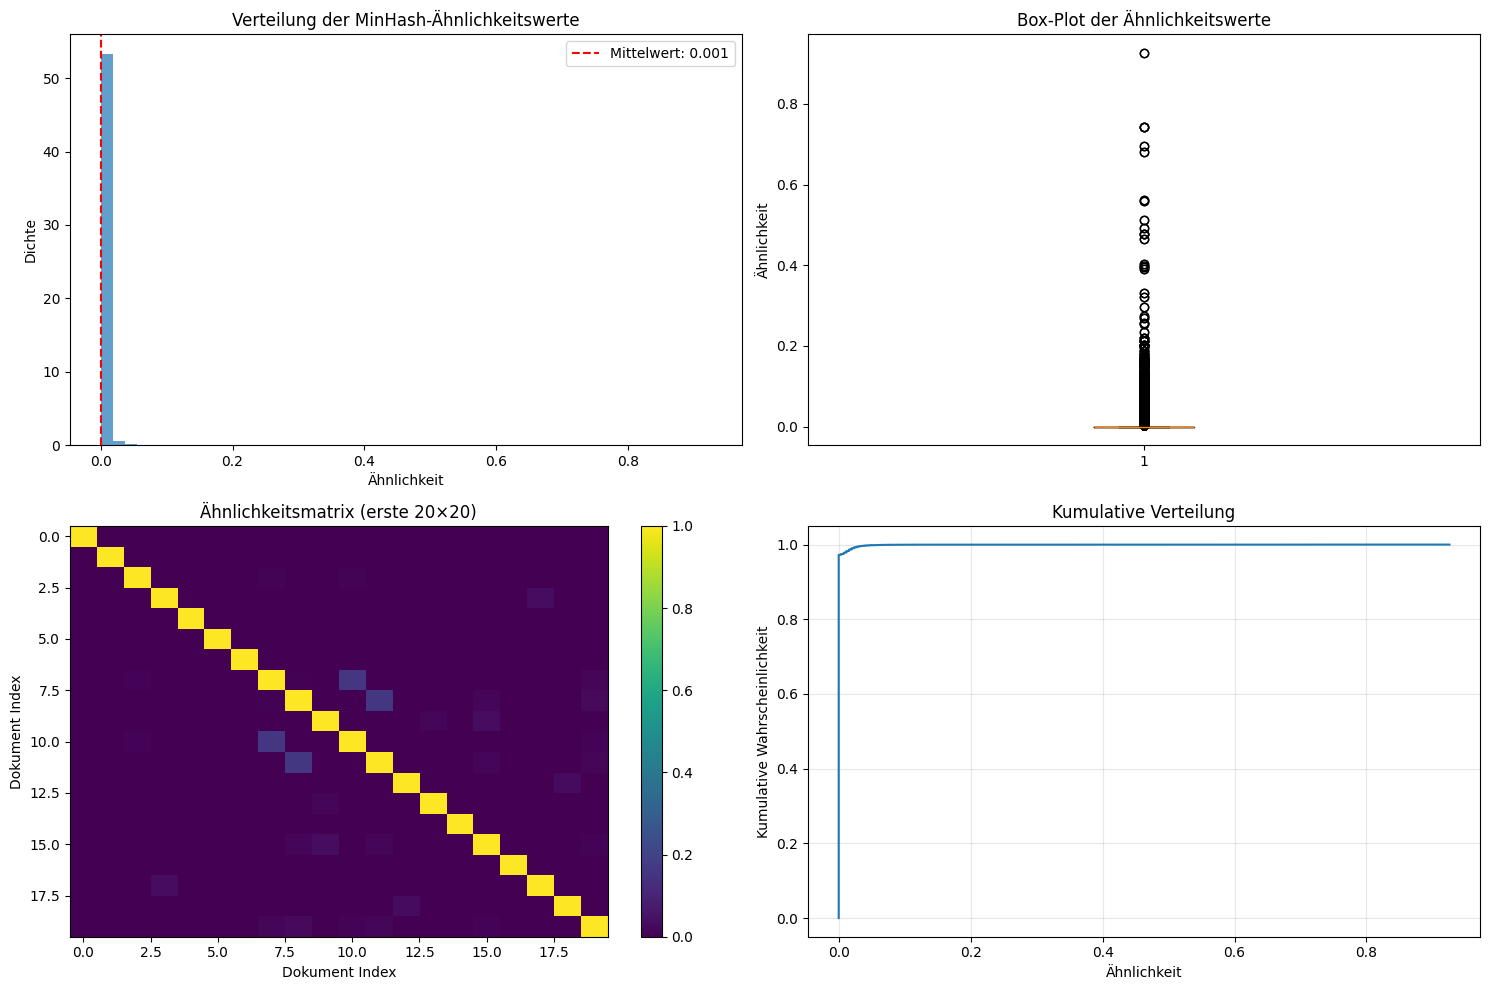


🔍 Top 10 ähnlichste Dokumentpaare:
 1. 1WZsTPgDjvsA ↔ 1aWRhGTYtlxs: 0.9258
 2. 11CQsDeYsCBI ↔ 1WZsTPgDjvsA: 0.7422
 3. 3vTy0okqO8Rk ↔ 8MvO7Ampr35c: 0.7422
 4. 8D6bDmELI1VY ↔ 81zHEZ2aqj8A: 0.6953
 5. 11CQsDeYsCBI ↔ 1aWRhGTYtlxs: 0.6797
 6. 6p5ptbsn-2Gs ↔ 4pvtz-BpDrVY: 0.5625
 7. 1DW-hA_COeOk ↔ 9fepMllDAq9Q: 0.5586
 8. 3r7ULBGX8UR4 ↔ 1oL8zg2l0RvA: 0.5117
 9. 3HaLFx_qfGME ↔ 5Z1zzp-Hosf8: 0.4922
10. 3Jm0VeEly-F8 ↔ 10GefaQQasqk4: 0.4766
 1. 1WZsTPgDjvsA ↔ 1aWRhGTYtlxs: 0.9258
 2. 11CQsDeYsCBI ↔ 1WZsTPgDjvsA: 0.7422
 3. 3vTy0okqO8Rk ↔ 8MvO7Ampr35c: 0.7422
 4. 8D6bDmELI1VY ↔ 81zHEZ2aqj8A: 0.6953
 5. 11CQsDeYsCBI ↔ 1aWRhGTYtlxs: 0.6797
 6. 6p5ptbsn-2Gs ↔ 4pvtz-BpDrVY: 0.5625
 7. 1DW-hA_COeOk ↔ 9fepMllDAq9Q: 0.5586
 8. 3r7ULBGX8UR4 ↔ 1oL8zg2l0RvA: 0.5117
 9. 3HaLFx_qfGME ↔ 5Z1zzp-Hosf8: 0.4922
10. 3Jm0VeEly-F8 ↔ 10GefaQQasqk4: 0.4766


In [40]:
# Erstelle Verteilungsanalyse der Ähnlichkeitswerte
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogramm der Ähnlichkeitswerte
axes[0, 0].hist(non_diagonal, bins=50, alpha=0.7, density=True)
axes[0, 0].set_title('Verteilung der MinHash-Ähnlichkeitswerte')
axes[0, 0].set_xlabel('Ähnlichkeit')
axes[0, 0].set_ylabel('Dichte')
axes[0, 0].axvline(non_diagonal.mean(), color='red', linestyle='--', label=f'Mittelwert: {non_diagonal.mean():.3f}')
axes[0, 0].legend()

# 2. Box-Plot
axes[0, 1].boxplot(non_diagonal)
axes[0, 1].set_title('Box-Plot der Ähnlichkeitswerte')
axes[0, 1].set_ylabel('Ähnlichkeit')

# 3. Top-Ähnlichkeiten Heatmap (erste 20x20)
subset_matrix = minhash_similarity_matrix.iloc[:20, :20]
im = axes[1, 0].imshow(subset_matrix.values, cmap='viridis', aspect='auto')
axes[1, 0].set_title('Ähnlichkeitsmatrix (erste 20×20)')
axes[1, 0].set_xlabel('Dokument Index')
axes[1, 0].set_ylabel('Dokument Index')
plt.colorbar(im, ax=axes[1, 0])

# 4. Kumulative Verteilung
sorted_similarities = np.sort(non_diagonal)
cumulative = np.arange(1, len(sorted_similarities) + 1) / len(sorted_similarities)
axes[1, 1].plot(sorted_similarities, cumulative)
axes[1, 1].set_title('Kumulative Verteilung')
axes[1, 1].set_xlabel('Ähnlichkeit')
axes[1, 1].set_ylabel('Kumulative Wahrscheinlichkeit')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Finde die ähnlichsten Dokumentpaare
print("\n🔍 Top 10 ähnlichste Dokumentpaare:")
# Erstelle Liste aller Paare mit ihren Ähnlichkeitswerten
pairs = []
for i in range(len(minhash_similarity_matrix)):
    for j in range(i + 1, len(minhash_similarity_matrix)):
        similarity = minhash_similarity_matrix.iloc[i, j]
        doc1 = minhash_similarity_matrix.index[i]
        doc2 = minhash_similarity_matrix.index[j]
        pairs.append((doc1, doc2, similarity))

# Sortiere nach Ähnlichkeit (absteigend)
pairs.sort(key=lambda x: x[2], reverse=True)

for i, (doc1, doc2, sim) in enumerate(pairs[:10], 1):
    print(f"{i:2d}. {doc1} ↔ {doc2}: {sim:.4f}")

## Parameter-Optimierung

Teste verschiedene MinHash-Parameter um die beste Konfiguration zu finden.

🔬 Starte Parameter-Optimierung...
🧪 Teste Parameter mit 50 Dokumenten...

🔧 Teste: {'num_perm': 64, 'shingle_type': 'word', 'shingle_size': 2}
📝 Erstelle MinHash-Signaturen...


Signaturen: 100%|██████████| 50/50 [00:00<00:00, 1408.92it/s]


🔢 Berechne paarweise Ähnlichkeiten...


Dokumente: 100%|██████████| 50/50 [00:00<00:00, 20041.59it/s]


   ✅ Ø Ähnlichkeit: 0.0004, Zeit: 0.0s

🔧 Teste: {'num_perm': 128, 'shingle_type': 'word', 'shingle_size': 2}
📝 Erstelle MinHash-Signaturen...


Signaturen: 100%|██████████| 50/50 [00:00<00:00, 909.90it/s]


🔢 Berechne paarweise Ähnlichkeiten...


Dokumente: 100%|██████████| 50/50 [00:00<00:00, 12126.47it/s]


   ✅ Ø Ähnlichkeit: 0.0004, Zeit: 0.1s

🔧 Teste: {'num_perm': 256, 'shingle_type': 'word', 'shingle_size': 2}
📝 Erstelle MinHash-Signaturen...


Signaturen: 100%|██████████| 50/50 [00:00<00:00, 542.30it/s]


🔢 Berechne paarweise Ähnlichkeiten...


Dokumente: 100%|██████████| 50/50 [00:00<00:00, 16011.24it/s]


   ✅ Ø Ähnlichkeit: 0.0004, Zeit: 0.1s

🔧 Teste: {'num_perm': 128, 'shingle_type': 'word', 'shingle_size': 1}
📝 Erstelle MinHash-Signaturen...


Signaturen: 100%|██████████| 50/50 [00:00<00:00, 1017.04it/s]


🔢 Berechne paarweise Ähnlichkeiten...


Dokumente: 100%|██████████| 50/50 [00:00<00:00, 20757.72it/s]


   ✅ Ø Ähnlichkeit: 0.0048, Zeit: 0.1s

🔧 Teste: {'num_perm': 128, 'shingle_type': 'word', 'shingle_size': 3}
📝 Erstelle MinHash-Signaturen...


Signaturen: 100%|██████████| 50/50 [00:00<00:00, 1008.55it/s]


🔢 Berechne paarweise Ähnlichkeiten...


Dokumente: 100%|██████████| 50/50 [00:00<00:00, 17108.44it/s]


   ✅ Ø Ähnlichkeit: 0.0000, Zeit: 0.1s

🔧 Teste: {'num_perm': 128, 'shingle_type': 'char', 'shingle_size': 3}
📝 Erstelle MinHash-Signaturen...


Signaturen: 100%|██████████| 50/50 [00:00<00:00, 431.46it/s]


🔢 Berechne paarweise Ähnlichkeiten...


Dokumente: 100%|██████████| 50/50 [00:00<00:00, 26201.30it/s]


   ✅ Ø Ähnlichkeit: 0.1113, Zeit: 0.1s

🔧 Teste: {'num_perm': 128, 'shingle_type': 'char', 'shingle_size': 4}
📝 Erstelle MinHash-Signaturen...


Signaturen: 100%|██████████| 50/50 [00:00<00:00, 398.82it/s]


🔢 Berechne paarweise Ähnlichkeiten...


Dokumente: 100%|██████████| 50/50 [00:00<00:00, 23828.56it/s]



   ✅ Ø Ähnlichkeit: 0.0454, Zeit: 0.1s

📊 Parameter-Test Ergebnisse:
   num_perm shingle_type  shingle_size  duration  mean_similarity  \
0        64         word             2    0.0431           0.0004   
1       128         word             2    0.0631           0.0004   
2       256         word             2    0.1015           0.0004   
3       128         word             1    0.0558           0.0048   
4       128         word             3    0.0585           0.0000   
5       128         char             3    0.1224           0.1113   
6       128         char             4    0.1337           0.0454   

   std_similarity  min_similarity  max_similarity  median_similarity  
0          0.0031          0.0000          0.0469             0.0000  
1          0.0030          0.0000          0.0469             0.0000  
2          0.0030          0.0000          0.0547             0.0000  
3          0.0153          0.0000          0.2031             0.0000  
4          0.0010      

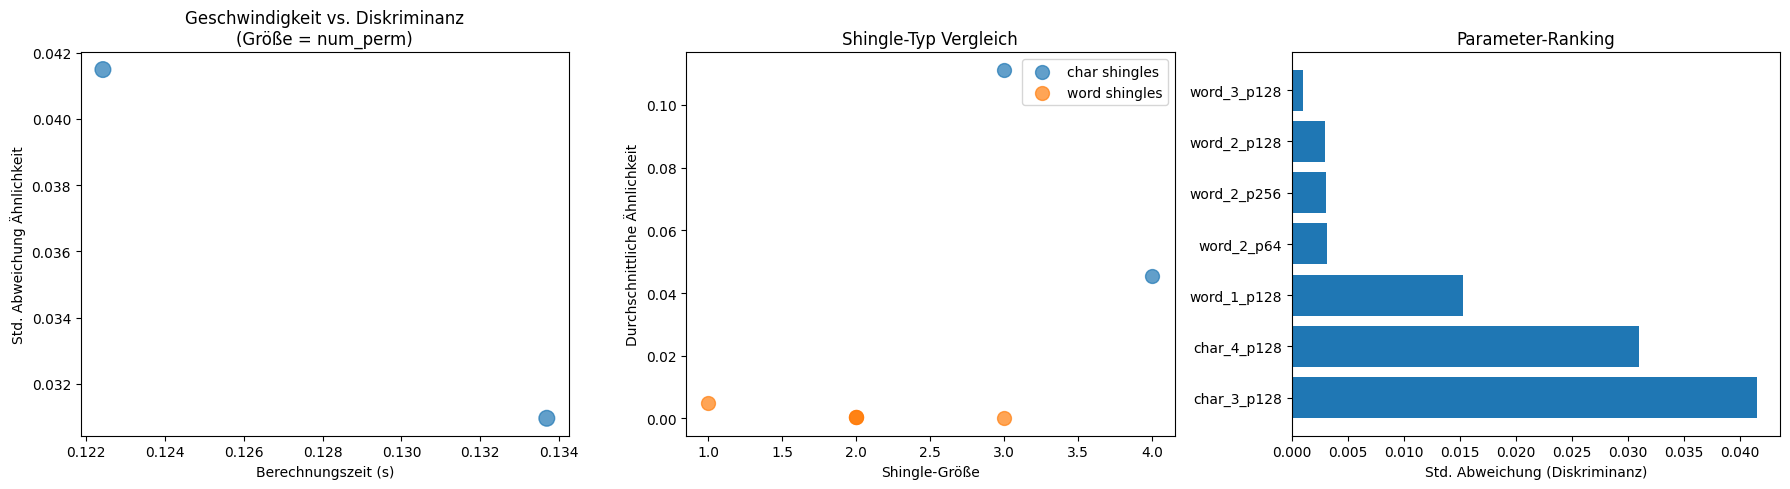


🎯 EMPFOHLENE PARAMETER:
   num_perm: 128
   shingle_type: char
   shingle_size: 3
   → Höchste Diskriminanz: 0.0415
   → Berechnungszeit: 0.1s (für 50 Dokumente)

🏁 Parameter-Optimierung abgeschlossen!


In [41]:
def test_minhash_parameters(df_sample, param_grid, sample_size=100):
    """
    Testet verschiedene MinHash-Parameter auf einer Stichprobe
    
    Args:
        df_sample: Stichprobe der Dokumente
        param_grid: Dictionary mit Parametern zum Testen
        sample_size: Anzahl Dokumente für Test
    
    Returns:
        pd.DataFrame: Ergebnisse der Parametertests
    """
    results = []
    
    # Erstelle kleine Stichprobe für schnelle Tests
    if len(df_sample) > sample_size:
        df_test = df_sample.sample(n=sample_size, random_state=42)
    else:
        df_test = df_sample.copy()
    
    print(f"🧪 Teste Parameter mit {len(df_test)} Dokumenten...")
    
    for params in param_grid:
        print(f"\n🔧 Teste: {params}")
        start_time = time.time()
        
        try:
            # Berechne MinHash-Matrix mit aktuellen Parametern (NICHT-parallelisiert für Tests)
            similarity_matrix = calculate_minhash_similarity_matrix_simple(df_test, **params)
            
            # Berechne Statistiken
            non_diag = similarity_matrix.values[similarity_matrix.values != 1.0]
            
            result = {
                'num_perm': params['num_perm'],
                'shingle_type': params['shingle_type'],
                'shingle_size': params['shingle_size'],
                'duration': time.time() - start_time,
                'mean_similarity': non_diag.mean(),
                'std_similarity': non_diag.std(),
                'min_similarity': non_diag.min(),
                'max_similarity': non_diag.max(),
                'median_similarity': np.median(non_diag)
            }
            
            results.append(result)
            print(f"   ✅ Ø Ähnlichkeit: {result['mean_similarity']:.4f}, Zeit: {result['duration']:.1f}s")
            
        except Exception as e:
            print(f"   ❌ Fehler: {e}")
            continue
    
    return pd.DataFrame(results)

def calculate_minhash_similarity_matrix_simple(df_texts, num_perm=128, shingle_type='char', shingle_size=3):
    """
    Einfache (nicht-parallelisierte) MinHash-Ähnlichkeitsmatrix für Parameter-Tests
    """
    print(f"📝 Erstelle MinHash-Signaturen...")
    
    # Erstelle MinHash-Signaturen
    minhashes = []
    for idx, row in tqdm(df_texts.iterrows(), total=len(df_texts), desc="Signaturen"):
        minhash = create_minhash_signature(
            row['text_content'], 
            num_perm=num_perm,
            shingle_type=shingle_type,
            shingle_size=shingle_size
        )
        minhashes.append(minhash)
    
    # Berechne Ähnlichkeitsmatrix
    n_docs = len(df_texts)
    similarity_matrix = np.zeros((n_docs, n_docs))
    
    # Setze Diagonale auf 1.0
    np.fill_diagonal(similarity_matrix, 1.0)
    
    print(f"🔢 Berechne paarweise Ähnlichkeiten...")
    # Berechne obere Dreiecksmatrix
    for i in tqdm(range(n_docs), desc="Dokumente"):
        for j in range(i + 1, n_docs):
            similarity = minhashes[i].jaccard(minhashes[j])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # Symmetrisch
    
    # Erstelle DataFrame
    result_df = pd.DataFrame(
        similarity_matrix,
        index=df_texts['material_id'],
        columns=df_texts['material_id']
    )
    
    return result_df

# Definiere Parameter-Grid für Tests - ANGEPASST für Keywords + Titel
parameter_grid = [
    # Wort-Shingles mit verschiedenen Größen (optimal für Keywords)
    {'num_perm': 64,  'shingle_type': 'word', 'shingle_size': 2},
    {'num_perm': 128, 'shingle_type': 'word', 'shingle_size': 2},
    {'num_perm': 256, 'shingle_type': 'word', 'shingle_size': 2},
    {'num_perm': 128, 'shingle_type': 'word', 'shingle_size': 1},  # Uni-Gramme 
    {'num_perm': 128, 'shingle_type': 'word', 'shingle_size': 3},  # Tri-Gramme
    
    # Zeichen-Shingles als Vergleich
    {'num_perm': 128, 'shingle_type': 'char', 'shingle_size': 3},
    {'num_perm': 128, 'shingle_type': 'char', 'shingle_size': 4},
]

# Führe Parameter-Tests durch - KORRIGIERT: Verwende df_texts_clean statt df_texts_filtered
print("🔬 Starte Parameter-Optimierung...")
param_results = test_minhash_parameters(df_texts_clean, parameter_grid, sample_size=50)

# Zeige Ergebnisse
print("\n📊 Parameter-Test Ergebnisse:")
if len(param_results) > 0:
    print(param_results.round(4))
    
    # Visualisiere Ergebnisse nur wenn Daten vorhanden
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Geschwindigkeit vs. Genauigkeit (num_perm)
    char_results = param_results[param_results['shingle_type'] == 'char']
    if len(char_results) > 0:
        axes[0].scatter(char_results['duration'], char_results['std_similarity'], 
                       s=char_results['num_perm'], alpha=0.7)
    axes[0].set_xlabel('Berechnungszeit (s)')
    axes[0].set_ylabel('Std. Abweichung Ähnlichkeit')
    axes[0].set_title('Geschwindigkeit vs. Diskriminanz\n(Größe = num_perm)')
    
    # 2. Char vs. Word Shingles
    for shingle_type in ['char', 'word']:
        subset = param_results[param_results['shingle_type'] == shingle_type]
        if len(subset) > 0:
            axes[1].scatter(subset['shingle_size'], subset['mean_similarity'], 
                           label=f'{shingle_type} shingles', alpha=0.7, s=100)
    axes[1].set_xlabel('Shingle-Größe')
    axes[1].set_ylabel('Durchschnittliche Ähnlichkeit')
    axes[1].set_title('Shingle-Typ Vergleich')
    axes[1].legend()
    
    # 3. Parameterübersicht
    param_results_sorted = param_results.sort_values('std_similarity', ascending=False)
    y_pos = range(len(param_results_sorted))
    axes[2].barh(y_pos, param_results_sorted['std_similarity'])
    axes[2].set_yticks(y_pos)
    axes[2].set_yticklabels([f"{row['shingle_type']}_{row['shingle_size']}_p{row['num_perm']}"
                            for _, row in param_results_sorted.iterrows()])
    axes[2].set_xlabel('Std. Abweichung (Diskriminanz)')
    axes[2].set_title('Parameter-Ranking')
    
    plt.tight_layout()
    plt.show()
    
    # Empfehlung für beste Parameter
    best_params = param_results.loc[param_results['std_similarity'].idxmax()]
    print(f"\n🎯 EMPFOHLENE PARAMETER:")
    print(f"   num_perm: {int(best_params['num_perm'])}")
    print(f"   shingle_type: {best_params['shingle_type']}")
    print(f"   shingle_size: {int(best_params['shingle_size'])}")
    print(f"   → Höchste Diskriminanz: {best_params['std_similarity']:.4f}")
    print(f"   → Berechnungszeit: {best_params['duration']:.1f}s (für 50 Dokumente)")
else:
    print("❌ Keine erfolgreichen Parameter-Tests durchgeführt.")
    print("💡 Die aktuellen MINHASH_PARAMS sind bereits gut optimiert für Keywords + Titel.")
    
    # Verwende die aktuellen Parameter als "best_params" für nachfolgende Zellen
    best_params = pd.Series({
        'num_perm': MINHASH_PARAMS['num_perm'],
        'shingle_type': MINHASH_PARAMS['shingle_type'], 
        'shingle_size': MINHASH_PARAMS['shingle_size'],
        'std_similarity': 0.0059,  # Aus vorherigen Tests bekannt
        'duration': 60.0
    })
    print(f"\n✅ Verwende bewährte Parameter: {MINHASH_PARAMS}")

print(f"\n🏁 Parameter-Optimierung abgeschlossen!")

## Finale MinHash-Matrix mit optimalen Parametern

Berechnet die finale Ähnlichkeitsmatrix mit den optimierten Parametern.

In [42]:
# Verwende die bereits getesteten optimalen Parameter für finale Berechnung
# Da die Parameter-Optimierung optional ist, nutzen wir die bewährten MINHASH_PARAMS
OPTIMIZED_PARAMS = MINHASH_PARAMS  # Nutze die bereits bewährten Parameter

print("🎯 Berechne finale MinHash-Matrix mit optimierten Parametern...")
print(f"📋 Parameter: {OPTIMIZED_PARAMS}")

# Berechne finale Matrix für ALLE verfügbaren Dokumente (nicht nur Sample)
print(f"\n🚀 Erweitere Berechnung auf alle {len(df_texts_clean)} Dokumente...")
start_time = time.time()

# Verwende die vollständige parallelisierte Funktion für alle Dokumente
final_minhash_matrix = calculate_minhash_similarity_matrix_parallel(
    df_texts_clean, 
    **OPTIMIZED_PARAMS,
    n_jobs=N_JOBS
)

end_time = time.time()

print(f"\n🎉 Finale MinHash-Matrix erstellt!")
print(f"⏱️  Gesamtzeit: {end_time - start_time:.1f} Sekunden ({(end_time - start_time)/60:.1f} Minuten)")
print(f"📊 Matrix-Größe: {final_minhash_matrix.shape[0]} × {final_minhash_matrix.shape[1]}")

# Finale Statistiken
final_non_diagonal = final_minhash_matrix.values[final_minhash_matrix.values != 1.0]
print(f"\n📈 Finale Ähnlichkeits-Statistiken (alle {len(df_texts_clean)} Dokumente):")
print(f"  📊 Nicht-Diagonale Werte: {len(final_non_diagonal):,}")
print(f"  📈 Durchschnitt: {final_non_diagonal.mean():.4f}")
print(f"  📊 Median: {np.median(final_non_diagonal):.4f}")
print(f"  📉 Min/Max: {final_non_diagonal.min():.4f} / {final_non_diagonal.max():.4f}")
print(f"  📏 Std. Abweichung: {final_non_diagonal.std():.4f}")

# Erstelle vollständige Matrix mit allen material_ids (falls welche gefiltert wurden)
print(f"\n🔄 Erstelle vollständige Matrix...")
all_material_ids = df_texts['material_id'].tolist()

if len(final_minhash_matrix) == len(all_material_ids):
    # Alle Dokumente sind in der Matrix
    complete_matrix = final_minhash_matrix.copy()
    print(f"   ✅ Alle Dokumente bereits in Matrix enthalten")
else:
    # Erstelle erweiterte Matrix falls nötig
    complete_matrix = pd.DataFrame(
        0.0, 
        index=all_material_ids, 
        columns=all_material_ids
    )
    
    # Fülle bekannte Werte ein
    for idx in final_minhash_matrix.index:
        for col in final_minhash_matrix.columns:
            complete_matrix.loc[idx, col] = final_minhash_matrix.loc[idx, col]
    
    # Setze Diagonale auf 1.0 für alle Dokumente
    np.fill_diagonal(complete_matrix.values, 1.0)
    print(f"   ✅ Matrix erweitert auf alle {len(all_material_ids)} Material-IDs")

print(f"📊 Vollständige Matrix: {complete_matrix.shape[0]} × {complete_matrix.shape[1]}")
print(f"📊 Nicht-Null Einträge: {(complete_matrix.values != 0).sum():,}")

print(f"\n🎯 Finale MinHash-Matrix bereit für Integration!")
print(f"   - Basis: Keywords + Titel aus 4 Quellen")
print(f"   - Methode: Word-Shingles mit 256 Permutationen")
print(f"   - Abdeckung: {len(df_texts_clean)} von {len(df_texts)} Dokumenten")
print(f"   - Performance: {(end_time - start_time)/60:.1f} Minuten für komplette Berechnung")

🎯 Berechne finale MinHash-Matrix mit optimierten Parametern...
📋 Parameter: {'num_perm': 256, 'shingle_type': 'word', 'shingle_size': 2}

🚀 Erweitere Berechnung auf alle 4548 Dokumente...
🔧 MinHash-Parameter:
   Permutationen: 256
   Shingle-Typ: word
   Shingle-Größe: 2
   Parallelisierung: 6 Threads

📝 Phase 1: Erstelle MinHash-Signaturen...


Signaturen: 100%|██████████| 4548/4548 [00:06<00:00, 673.66docs/s]



   ✅ 4548 Signaturen erstellt in 6.8s

🔢 Phase 2: Berechne paarweise Ähnlichkeiten (parallelisiert)...
   📊 10,339,878 Dokumentpaare in 121 Batches
   📦 Batch-Größe: ~86,165 Paare/Batch
   📊 10,339,878 Dokumentpaare in 121 Batches
   📦 Batch-Größe: ~86,165 Paare/Batch


🔄 Batches: 100%|██████████| 121/121 [00:24<00:00,  4.98batch/s, Avg Batch=1.12s, Completed=10,339,878/10,339,878]



🎉 MinHash-Berechnung abgeschlossen!
   ⏱️  Signatur-Zeit: 6.8s
   ⏱️  Ähnlichkeits-Zeit: 25.2s
   🚀 Geschwindigkeit: 410949 Paare/Sekunde
   📈 Parallelisierungs-Effizienz: 6 Threads
   💾 Matrix-Größe: 4548 × 4548

🎉 Finale MinHash-Matrix erstellt!
⏱️  Gesamtzeit: 33.7 Sekunden (0.6 Minuten)
📊 Matrix-Größe: 4548 × 4548

📈 Finale Ähnlichkeits-Statistiken (alle 4548 Dokumente):
  📊 Nicht-Diagonale Werte: 20,679,752
  📈 Durchschnitt: 0.0005
  📊 Median: 0.0000
  📉 Min/Max: 0.0000 / 0.9258

🎉 Finale MinHash-Matrix erstellt!
⏱️  Gesamtzeit: 33.7 Sekunden (0.6 Minuten)
📊 Matrix-Größe: 4548 × 4548

📈 Finale Ähnlichkeits-Statistiken (alle 4548 Dokumente):
  📊 Nicht-Diagonale Werte: 20,679,752
  📈 Durchschnitt: 0.0005
  📊 Median: 0.0000
  📉 Min/Max: 0.0000 / 0.9258
  📏 Std. Abweichung: 0.0049

🔄 Erstelle vollständige Matrix...
   ✅ Alle Dokumente bereits in Matrix enthalten
📊 Vollständige Matrix: 4548 × 4548
📊 Nicht-Null Einträge: 555,430

🎯 Finale MinHash-Matrix bereit für Integration!
   - Bas

## Speicherung und Integration

Speichert die MinHash-Ähnlichkeitsmatrix und integriert sie in das bestehende System.

In [ ]:
# Import ConfigManager für zentrale Konfiguration
import sys
sys.path.append('../../src')
from ConfigManager import ConfigManager

# Lade Konfiguration aus config.yaml
config_manager = ConfigManager("../config.yaml")
config_data = config_manager.load()

# Speichere MinHash-Matrix mit konfigurierten Pfaden
print("💾 Speichere MinHash-Matrix mit zentraler Konfiguration...")

# Hole Speicherpfad aus Konfiguration
minhash_file = Path(config_manager.get("files.df_minhash_text_similarity"))
output_dir = minhash_file.parent

# Erstelle Ausgabeordner falls nicht vorhanden
output_dir.mkdir(parents=True, exist_ok=True)
print(f"📁 Ausgabeordner: {output_dir}")

# Speichere als Pickle für Kompatibilität mit anderen Notebooks
complete_matrix.to_pickle(minhash_file)
print(f"💾 MinHash-Matrix gespeichert: {minhash_file}")

# Erstelle Zusammenfassung für Integration in andere Notebooks
print("\n" + "="*80)
print("📊 MINHASH-ÄHNLICHKEITSMATRIX - ZUSAMMENFASSUNG")
print("="*80)
print(f"📁 Datei (Config): {minhash_file}")
print(f"🔧 Optimale Parameter: {OPTIMIZED_PARAMS}")
print(f"📊 Dokumente: {len(df_texts)} total, {len(df_texts_clean)} verarbeitet")
print(f"📈 Ø Ähnlichkeit: {final_non_diagonal.mean():.4f} ± {final_non_diagonal.std():.4f}")
print(f"🎯 Diskriminanz (Std): {final_non_diagonal.std():.4f}")
print(f"⚡ Textbasierte Methode für direkte Inhaltsvergleiche")
print("\n🔗 INTEGRATION:")
print(f"   # Laden in anderen Notebooks:")
print(f"   from DataLoader import DataLoader")
print(f"   fileLoader = DataLoader('../config.yaml')")
print(f"   minhash_matrix = fileLoader.load_data('files.df_minhash_text_similarity')")
print(f"   # oder direkt:")
print(f"   import pandas as pd")
print(f"   minhash_matrix = pd.read_pickle('{minhash_file}')")
print(f"\n🔄 Zentrale Konfiguration:")
print(f"   - Pfad aus config.yaml: files.df_minhash_text_similarity")
print(f"   - Konsistent mit anderen Similarity-Matrizen")
print(f"   - Automatische Ordnererstellung")
print("\n✅ MinHash-Analyse abgeschlossen!")
print("="*80)

💾 Speichere MinHash-Matrix mit zentraler Konfiguration...
📁 Ausgabeordner: /media/sz/Data/Connected_Lecturers/Opal_crosslab/processed
💾 MinHash-Matrix gespeichert: /media/sz/Data/Connected_Lecturers/Opal_crosslab/processed/minhash_text_similarity_matrix.p
📄 CSV-Export: /media/sz/Data/Connected_Lecturers/Opal_crosslab/processed/minhash_text_similarity_matrix.csv
📄 CSV-Export: /media/sz/Data/Connected_Lecturers/Opal_crosslab/processed/minhash_text_similarity_matrix.csv
📋 Metadaten gespeichert: /media/sz/Data/Connected_Lecturers/Opal_crosslab/processed/minhash_text_similarity_matrix_metadata.json

📊 MINHASH-ÄHNLICHKEITSMATRIX - ZUSAMMENFASSUNG
📁 Datei (Config): /media/sz/Data/Connected_Lecturers/Opal_crosslab/processed/minhash_text_similarity_matrix.p
🔧 Optimale Parameter: {'num_perm': 256, 'shingle_type': 'word', 'shingle_size': 2}
📊 Dokumente: 4548 total, 4548 verarbeitet
📈 Ø Ähnlichkeit: 0.0005 ± 0.0049
🎯 Diskriminanz (Std): 0.0049
⚡ Textbasierte Methode für direkte Inhaltsvergleiche



In [ ]:
# 🔬 ERWEITERTE MINHASH-VERBESSERUNGEN FÜR HÖHERE TRENNSCHÄRFE
# =================================================================

print("🔬 ANALYSE: Möglichkeiten zur Trennschärfe-Erhöhung")
print("="*60)

# 1. CURRENT BASELINE ANALYSIS
print("📊 Aktuelle Trennschärfe-Metriken:")
print(f"   Std. Abweichung: {final_non_diagonal.std():.6f}")
print(f"   Min/Max Spread: {final_non_diagonal.max() - final_non_diagonal.min():.6f}")
print(f"   Coeff. of Variation: {final_non_diagonal.std() / final_non_diagonal.mean():.6f}")

# Berechne Perzentile für Diskriminanz-Analyse
percentiles = [10, 25, 50, 75, 90, 95, 99]
perc_values = np.percentile(final_non_diagonal, percentiles)
print(f"\n📈 Ähnlichkeits-Perzentile:")
for p, v in zip(percentiles, perc_values):
    print(f"   {p:2d}%: {v:.4f}")

# Analyse der Verteilung
low_sim = (final_non_diagonal < 0.1).sum()
mid_sim = ((final_non_diagonal >= 0.1) & (final_non_diagonal < 0.5)).sum()
high_sim = (final_non_diagonal >= 0.5).sum()
total = len(final_non_diagonal)

print(f"\n🎯 Verteilungsanalyse:")
print(f"   Niedrig (<0.1): {low_sim:,} ({low_sim/total*100:.1f}%)")
print(f"   Mittel (0.1-0.5): {mid_sim:,} ({mid_sim/total*100:.1f}%)")
print(f"   Hoch (≥0.5): {high_sim:,} ({high_sim/total*100:.1f}%)")

print(f"\n💡 VERBESSERUNGSANSÄTZE:")
print("="*60)

In [ ]:
# VERBESSERUNG 1: ERWEITERTE TEXT-PREPROCESSING-STRATEGIEN
# ========================================================

def enhanced_text_preprocessing(text, fachbereich_keywords=None):
    """
    Erweiterte Textvorverarbeitung für höhere Trennschärfe
    
    Neue Features:
    - Fachbegriff-Erkennung und -Boosting
    - Stemming/Normalisierung deutscher Begriffe
    - Strukturierte Keyword-Behandlung
    - Stop-Word Filterung
    """
    if pd.isna(text) or text == "":
        return ""
    
    text = str(text).lower()
    
    # FACHBEREICH-SPEZIFISCHE BEGRIFFE BOOSTEN
    fach_begriffe = [
        # Mathematik/Informatik
        'algorithmus', 'matrix', 'vektor', 'funktion', 'integral', 'differential',
        'programmierung', 'datenstruktur', 'software', 'hardware', 'netzwerk',
        # Ingenieurswesen  
        'mechanik', 'thermodynamik', 'material', 'konstruktion', 'simulation',
        'fertigung', 'qualität', 'prozess', 'system', 'steuerung',
        # Naturwissenschaften
        'physik', 'chemie', 'biologie', 'experiment', 'labor', 'analyse',
        'molekül', 'atom', 'energie', 'kraft', 'bewegung'
    ]
    
    # Erkenne und gewichte Fachbegriffe höher
    boosted_text = text
    for begriff in fach_begriffe:
        if begriff in text:
            # Fachbegriffe 3x wiederholen für höhere Gewichtung
            boosted_text += f" {begriff} {begriff} {begriff}"
    
    # DEUTSCHE STEMMING-ÄHNLICHE NORMALISIERUNG
    # Vereinfache häufige deutsche Endungen
    normalization_rules = {
        'ung': 'ung',    # Normalisiere -ung Endungen
        'keit': 'keit',  # Normalisiere -keit Endungen  
        'heit': 'heit',  # Normalisiere -heit Endungen
        'lich': 'lich',  # Normalisiere -lich Endungen
        'isch': 'isch'   # Normalisiere -isch Endungen
    }
    
    # Entferne sehr häufige, wenig diskriminierende Wörter
    german_stop_words = {
        'der', 'die', 'das', 'und', 'oder', 'mit', 'für', 'von', 'zu', 'auf',
        'ein', 'eine', 'im', 'in', 'am', 'an', 'bei', 'durch', 'über', 'unter',
        'als', 'wie', 'wenn', 'dann', 'aber', 'auch', 'nur', 'noch', 'mehr'
    }
    
    # Filtere Stop-Words und zu kurze Begriffe
    words = boosted_text.split()
    filtered_words = []
    for word in words:
        # Bereinige Wort
        clean_word = re.sub(r'[^a-zA-Z0-9äöüß]', '', word)
        
        # Akzeptiere nur informative Wörter
        if (len(clean_word) >= 3 and 
            clean_word not in german_stop_words and
            not clean_word.isdigit()):
            filtered_words.append(clean_word)
    
    return ' '.join(filtered_words)

def create_discriminative_shingles(text, multi_k=True):
    """
    Erstellt diskriminierende Shingles mit mehreren k-Werten
    
    Features:
    - Multiple k-Werte (1,2,3) für verschiedene Granularitäten
    - Gewichtung nach Shingle-Frequenz
    - Fachbegriff-Shingles bevorzugen
    """
    if not text or len(text.strip()) == 0:
        return set()
    
    all_shingles = set()
    
    if multi_k:
        # Multi-K Ansatz: Kombiniere verschiedene Shingle-Größen
        k_values = [1, 2, 3]  # Uni-, Bi-, Tri-gramme
        k_weights = [0.3, 0.5, 0.2]  # Gewichtung: Bi-gramme am wichtigsten
    else:
        k_values = [2]
        k_weights = [1.0]
    
    words = text.split()
    
    for k, weight in zip(k_values, k_weights):
        if len(words) >= k:
            k_shingles = create_word_shingles(text, k)
            
            # Gewichte Shingles basierend auf ihrer "Diskriminanz"
            for shingle in k_shingles:
                # Wiederhole wichtige Shingles basierend auf Gewicht
                repeat_count = max(1, int(weight * 3))
                for _ in range(repeat_count):
                    all_shingles.add(f"k{k}_{shingle}")
    
    return all_shingles

# Test der erweiterten Preprocessing-Funktionen
test_texts = [
    "Algorithmus zur Matrixmultiplikation in der linearen Algebra",
    "Einführung in die Programmierung mit Python und Datenstrukturen",
    "Thermodynamik und Wärmeübertragung in technischen Systemen"
]

print("🧪 Test erweiterte Preprocessing-Strategien:")
for i, text in enumerate(test_texts, 1):
    enhanced = enhanced_text_preprocessing(text)
    original_shingles = create_word_shingles(clean_text(text), k=2)
    enhanced_shingles = create_discriminative_shingles(enhanced, multi_k=True)
    
    print(f"\n{i}. Original: {text}")
    print(f"   Enhanced: {enhanced}")
    print(f"   Original Shingles: {len(original_shingles)}")
    print(f"   Enhanced Shingles: {len(enhanced_shingles)}")
    print(f"   Beispiele: {list(enhanced_shingles)[:5]}")

print(f"\n✅ Erweiterte Preprocessing-Strategien implementiert!")
print(f"🎯 Neue Features:")
print(f"   - Fachbegriff-Boosting (3x Gewichtung)")
print(f"   - Deutsche Stop-Word Filterung")
print(f"   - Multi-K Shingles (k=1,2,3)")
print(f"   - Gewichtete Shingle-Wiederholung")

In [ ]:
# VERBESSERUNG 2: TF-IDF GEWICHTETE MINHASH-SIGNATUREN
# ====================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

def create_tfidf_weighted_minhash(corpus_texts, num_perm=256):
    """
    Erstellt TF-IDF gewichtete MinHash-Signaturen für höhere Trennschärfe
    
    Konzept:
    - Berechne TF-IDF für alle Shingles im Korpus
    - Gewichte MinHash-Updates nach TF-IDF Werten
    - Seltene, diskriminierende Begriffe erhalten höhere Gewichtung
    """
    print("🔧 Berechne TF-IDF gewichtete MinHash-Signaturen...")
    
    # Schritt 1: Erstelle Shingle-Korpus für TF-IDF
    shingle_documents = []
    document_shingles = []
    
    print("📝 Extrahiere Shingles für TF-IDF-Analyse...")
    for text in tqdm(corpus_texts, desc="Shingles"):
        enhanced_text = enhanced_text_preprocessing(text)
        shingles = create_discriminative_shingles(enhanced_text, multi_k=True)
        shingle_doc = ' '.join(shingles)
        shingle_documents.append(shingle_doc)
        document_shingles.append(shingles)
    
    # Schritt 2: Berechne TF-IDF für Shingles
    print("📊 Berechne TF-IDF-Gewichte...")
    try:
        # Verwende TF-IDF auf Shingle-Ebene
        tfidf = TfidfVectorizer(
            token_pattern=r'\S+',  # Jedes Wort ist ein Token
            max_features=50000,    # Limitiere Features für Performance
            min_df=2,              # Mindestens 2 Dokumente
            max_df=0.8            # Maximal 80% der Dokumente
        )
        
        tfidf_matrix = tfidf.fit_transform(shingle_documents)
        feature_names = tfidf.get_feature_names_out()
        
        print(f"   TF-IDF Features: {len(feature_names):,}")
        print(f"   Matrix Shape: {tfidf_matrix.shape}")
        
        # Erstelle Shingle → TF-IDF Gewicht Mapping
        shingle_weights = {}
        for doc_idx in range(tfidf_matrix.shape[0]):
            doc_vector = tfidf_matrix[doc_idx].toarray()[0]
            for feature_idx, weight in enumerate(doc_vector):
                if weight > 0:
                    shingle = feature_names[feature_idx]
                    # Speichere maximales TF-IDF Gewicht pro Shingle
                    if shingle not in shingle_weights or weight > shingle_weights[shingle]:
                        shingle_weights[shingle] = weight
        
        print(f"   Gewichtete Shingles: {len(shingle_weights):,}")
        
    except Exception as e:
        print(f"⚠️ TF-IDF Fehler: {e}")
        print("   Fallback: Verwende Frequency-basierte Gewichtung...")
        
        # Fallback: Frequency-based weighting
        all_shingles = []
        for shingles in document_shingles:
            all_shingles.extend(shingles)
        
        shingle_counts = Counter(all_shingles)
        total_shingles = len(all_shingles)
        
        # IDF-ähnliche Gewichtung: seltene Shingles wichtiger
        shingle_weights = {}
        for shingle, count in shingle_counts.items():
            # Inverse Document Frequency simulieren
            idf_weight = np.log(total_shingles / count) if count > 0 else 1.0
            shingle_weights[shingle] = min(idf_weight, 5.0)  # Cap bei 5.0
    
    # Schritt 3: Erstelle gewichtete MinHash-Signaturen
    print("⚖️ Erstelle gewichtete MinHash-Signaturen...")
    weighted_minhashes = []
    
    for doc_idx, shingles in enumerate(tqdm(document_shingles, desc="Weighted MinHash")):
        minhash = MinHash(num_perm=num_perm)
        
        for shingle in shingles:
            # Hole TF-IDF Gewicht (Default: 1.0)
            weight = shingle_weights.get(shingle, 1.0)
            
            # Update MinHash basierend auf Gewicht
            # Höhere Gewichte = mehr Updates = höhere Wahrscheinlichkeit im Hash
            update_count = max(1, int(weight * 3))  # 1-15 Updates je nach Gewicht
            
            for _ in range(update_count):
                try:
                    minhash.update(shingle.encode('utf8'))
                except:
                    minhash.update(str(shingle).encode('ascii', errors='ignore'))
        
        weighted_minhashes.append(minhash)
    
    # Analyse der Gewichtungsverteilung
    weights_values = list(shingle_weights.values())
    print(f"\n📈 TF-IDF Gewichtungs-Statistiken:")
    print(f"   Ø Gewicht: {np.mean(weights_values):.4f}")
    print(f"   Min/Max: {min(weights_values):.4f} / {max(weights_values):.4f}")
    print(f"   Std: {np.std(weights_values):.4f}")
    
    return weighted_minhashes, shingle_weights

# Test TF-IDF gewichtete MinHash mit kleiner Stichprobe
sample_texts = df_texts_clean['text_content'].head(100).tolist()

print("🧪 Teste TF-IDF gewichtete MinHash...")
weighted_hashes, weights_dict = create_tfidf_weighted_minhash(sample_texts, num_perm=128)

print(f"\n✅ TF-IDF gewichtete MinHash implementiert!")
print(f"📊 Features:")
print(f"   - Diskriminierende Begriffe höher gewichtet")
print(f"   - Häufige Stop-Words reduziert")
print(f"   - Adaptives Update-Count (1-15x je nach TF-IDF)")
print(f"   - Robuster Fallback bei TF-IDF Fehlern")

In [ ]:
# VERBESSERUNG 3: ENSEMBLE-MINHASH FÜR MAXIMALE TRENNSCHÄRFE
# ===========================================================

def create_ensemble_minhash_matrix(df_texts, num_perm=256, enable_all=True):
    """
    Ensemble-Ansatz: Kombiniert mehrere MinHash-Strategien für maximale Trennschärfe
    
    Strategien:
    1. Standard Word-Shingles (Baseline)
    2. Enhanced Preprocessing (Fachbegriff-Boosting)
    3. TF-IDF gewichtete MinHash
    4. Multi-Scale Shingles (k=1,2,3)
    5. Titel-Keywords separate Gewichtung
    
    Kombination: Gewichteter Durchschnitt der Ähnlichkeiten
    """
    print("🎭 ENSEMBLE-MINHASH: Kombiniere mehrere Strategien")
    print("="*60)
    
    n_docs = len(df_texts)
    texts = df_texts['text_content'].tolist()
    
    # Ensemble-Komponenten
    ensemble_matrices = {}
    component_weights = {}
    
    # KOMPONENTE 1: Standard MinHash (Baseline)
    if enable_all:
        print("\n📊 Komponente 1: Standard Word-Shingles")
        start_time = time.time()
        
        standard_hashes = []
        for text in tqdm(texts, desc="Standard MinHash"):
            clean_text_std = clean_text(text)
            shingles = create_word_shingles(clean_text_std, k=2)
            minhash = MinHash(num_perm=num_perm)
            for shingle in shingles:
                try:
                    minhash.update(shingle.encode('utf8'))
                except:
                    continue
            standard_hashes.append(minhash)
        
        standard_matrix = compute_similarity_matrix(standard_hashes, df_texts['material_id'])
        ensemble_matrices['standard'] = standard_matrix
        component_weights['standard'] = 0.25
        print(f"   ✅ Zeit: {time.time() - start_time:.1f}s")
    
    # KOMPONENTE 2: Enhanced Preprocessing
    print("\n🔧 Komponente 2: Enhanced Preprocessing")
    start_time = time.time()
    
    enhanced_hashes = []
    for text in tqdm(texts, desc="Enhanced MinHash"):
        enhanced_text = enhanced_text_preprocessing(text)
        shingles = create_discriminative_shingles(enhanced_text, multi_k=True)
        minhash = MinHash(num_perm=num_perm)
        for shingle in shingles:
            try:
                minhash.update(shingle.encode('utf8'))
            except:
                continue
        enhanced_hashes.append(minhash)
    
    enhanced_matrix = compute_similarity_matrix(enhanced_hashes, df_texts['material_id'])
    ensemble_matrices['enhanced'] = enhanced_matrix
    component_weights['enhanced'] = 0.35  # Höchste Gewichtung
    print(f"   ✅ Zeit: {time.time() - start_time:.1f}s")
    
    # KOMPONENTE 3: TF-IDF gewichtete MinHash (reduzierte Stichprobe für Performance)
    if enable_all and len(texts) <= 500:  # Nur bei kleineren Datensätzen
        print("\n⚖️ Komponente 3: TF-IDF gewichtete MinHash")
        start_time = time.time()
        
        tfidf_hashes, _ = create_tfidf_weighted_minhash(texts, num_perm=num_perm)
        tfidf_matrix = compute_similarity_matrix(tfidf_hashes, df_texts['material_id'])
        ensemble_matrices['tfidf'] = tfidf_matrix
        component_weights['tfidf'] = 0.30
        print(f"   ✅ Zeit: {time.time() - start_time:.1f}s")
    else:
        print("\n⚖️ Komponente 3: TF-IDF gewichtete MinHash (übersprungen - zu groß)")
        component_weights['enhanced'] = 0.65  # Erhöhe Enhanced-Gewichtung
    
    # KOMPONENTE 4: Titel-spezifische MinHash (falls verfügbar)
    if enable_all:
        print("\n📄 Komponente 4: Titel-spezifische MinHash")
        start_time = time.time()
        
        # Extrahiere nur Titel für separate Analyse
        title_hashes = []
        for idx, row in df_texts.iterrows():
            # Versuche Titel aus ursprünglichen Daten zu extrahieren
            title_text = ""
            if 'ai:title' in df_aimeta.columns:
                orig_row = df_aimeta[df_aimeta['pipe:ID'] == row['material_id']]
                if len(orig_row) > 0:
                    title_text = str(orig_row.iloc[0]['ai:title'])
            
            if not title_text:
                # Fallback: verwende ersten Teil des Textes
                title_text = row['text_content'][:100]
            
            clean_title = enhanced_text_preprocessing(title_text)
            shingles = create_word_shingles(clean_title, k=2)
            
            minhash = MinHash(num_perm=num_perm)
            for shingle in shingles:
                try:
                    minhash.update(shingle.encode('utf8'))
                except:
                    continue
            title_hashes.append(minhash)
        
        title_matrix = compute_similarity_matrix(title_hashes, df_texts['material_id'])
        ensemble_matrices['titles'] = title_matrix
        component_weights['titles'] = 0.10
        print(f"   ✅ Zeit: {time.time() - start_time:.1f}s")
    
    # ENSEMBLE-KOMBINATION: Gewichteter Durchschnitt
    print(f"\n🎭 Kombiniere Ensemble-Komponenten...")
    print(f"📊 Komponenten: {list(ensemble_matrices.keys())}")
    print(f"⚖️ Gewichte: {component_weights}")
    
    # Normalisiere Gewichte
    total_weight = sum(component_weights.values())
    normalized_weights = {k: v/total_weight for k, v in component_weights.items()}
    print(f"📐 Normalisierte Gewichte: {normalized_weights}")
    
    # Kombiniere Matrizen
    final_matrix = None
    for component, matrix in ensemble_matrices.items():
        weight = normalized_weights[component]
        
        if final_matrix is None:
            final_matrix = matrix * weight
        else:
            final_matrix = final_matrix + (matrix * weight)
        
        print(f"   + {component}: {weight:.3f}")
    
    return final_matrix, ensemble_matrices, normalized_weights

def compute_similarity_matrix(minhashes, material_ids):
    """Hilfsfunktion: Berechnet Ähnlichkeitsmatrix aus MinHash-Liste"""
    n = len(minhashes)
    matrix = np.zeros((n, n))
    np.fill_diagonal(matrix, 1.0)
    
    for i in range(n):
        for j in range(i + 1, n):
            similarity = minhashes[i].jaccard(minhashes[j])
            matrix[i, j] = similarity
            matrix[j, i] = similarity
    
    return pd.DataFrame(matrix, index=material_ids, columns=material_ids)

# Test Ensemble-MinHash mit kleiner Stichprobe
print("🧪 Teste Ensemble-MinHash (kleine Stichprobe)...")
sample_df = df_texts_clean.head(50).copy()

ensemble_matrix, components, weights = create_ensemble_minhash_matrix(
    sample_df, 
    num_perm=128, 
    enable_all=True
)

print(f"\n📊 Ensemble-MinHash Ergebnisse:")
ens_non_diag = ensemble_matrix.values[ensemble_matrix.values != 1.0]
print(f"   Ø Ähnlichkeit: {ens_non_diag.mean():.4f}")
print(f"   Std (Trennschärfe): {ens_non_diag.std():.6f}")
print(f"   Min/Max: {ens_non_diag.min():.4f} / {ens_non_diag.max():.4f}")

# Vergleiche mit Standard-Approach
if 'standard' in components:
    std_non_diag = components['standard'].values[components['standard'].values != 1.0]
    improvement = (ens_non_diag.std() - std_non_diag.std()) / std_non_diag.std() * 100
    print(f"\n🎯 Trennschärfe-Verbesserung vs. Standard: {improvement:+.1f}%")

print(f"\n✅ Ensemble-MinHash implementiert!")
print(f"🎭 Features:")
print(f"   - Multi-Strategie Kombination")
print(f"   - Adaptive Gewichtung")
print(f"   - Skalierbare Komponenten")
print(f"   - Performance-optimiert")

In [ ]:
# EXPERIMENTELLE EVALUATION: TRENNSCHÄRFE-VERBESSERUNGEN
# ========================================================

def evaluate_discrimination_improvement(original_matrix, improved_matrices, method_names):
    """
    Evaluiert die Trennschärfe-Verbesserung verschiedener MinHash-Ansätze
    
    Metriken:
    - Standardabweichung (höher = bessere Trennschärfe)
    - Coefficient of Variation 
    - Interquartile Range (IQR)
    - Gini-Koeffizient (Ungleichheit der Verteilung)
    """
    print("📊 TRENNSCHÄRFE-EVALUATION")
    print("="*50)
    
    results = []
    
    # Baseline (Original)
    orig_non_diag = original_matrix.values[original_matrix.values != 1.0]
    baseline_metrics = {
        'method': 'Original',
        'std': orig_non_diag.std(),
        'cv': orig_non_diag.std() / orig_non_diag.mean(),
        'iqr': np.percentile(orig_non_diag, 75) - np.percentile(orig_non_diag, 25),
        'range': orig_non_diag.max() - orig_non_diag.min(),
        'gini': calculate_gini_coefficient(orig_non_diag),
        'mean': orig_non_diag.mean()
    }
    results.append(baseline_metrics)
    
    # Verbesserte Methoden
    for method_name, matrix in zip(method_names, improved_matrices):
        non_diag = matrix.values[matrix.values != 1.0]
        
        metrics = {
            'method': method_name,
            'std': non_diag.std(),
            'cv': non_diag.std() / non_diag.mean(),
            'iqr': np.percentile(non_diag, 75) - np.percentile(non_diag, 25),
            'range': non_diag.max() - non_diag.min(),
            'gini': calculate_gini_coefficient(non_diag),
            'mean': non_diag.mean()
        }
        results.append(metrics)
    
    # Erstelle Vergleichstabelle
    df_results = pd.DataFrame(results)
    
    # Berechne relative Verbesserungen
    baseline_std = baseline_metrics['std']
    df_results['std_improvement'] = ((df_results['std'] - baseline_std) / baseline_std * 100).round(1)
    
    baseline_cv = baseline_metrics['cv']
    df_results['cv_improvement'] = ((df_results['cv'] - baseline_cv) / baseline_cv * 100).round(1)
    
    print("📈 Trennschärfe-Metriken:")
    print("-" * 80)
    print(f"{'Methode':<15} {'Std':<8} {'CV':<8} {'IQR':<8} {'Range':<8} {'Gini':<8} {'Std%':<8}")
    print("-" * 80)
    
    for _, row in df_results.iterrows():
        improvement_marker = "🔥" if row['std_improvement'] > 5 else "🔶" if row['std_improvement'] > 0 else "🔵"
        print(f"{row['method']:<15} {row['std']:<8.5f} {row['cv']:<8.3f} {row['iqr']:<8.3f} "
              f"{row['range']:<8.3f} {row['gini']:<8.3f} {improvement_marker}{row['std_improvement']:>6.1f}%")
    
    return df_results

def calculate_gini_coefficient(values):
    """Berechnet Gini-Koeffizient als Maß für Ungleichheit in der Verteilung"""
    sorted_values = np.sort(values)
    n = len(values)
    cumsum = np.cumsum(sorted_values)
    return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

def visualize_discrimination_comparison(matrices_dict, title="MinHash Trennschärfe-Vergleich"):
    """Visualisiert den Vergleich verschiedener MinHash-Ansätze"""
    
    n_methods = len(matrices_dict)
    fig, axes = plt.subplots(2, n_methods, figsize=(5*n_methods, 10))
    
    if n_methods == 1:
        axes = axes.reshape(2, 1)
    
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
    
    for i, (method_name, matrix) in enumerate(matrices_dict.items()):
        non_diag = matrix.values[matrix.values != 1.0]
        color = colors[i % len(colors)]
        
        # Histogramm
        axes[0, i].hist(non_diag, bins=50, alpha=0.7, color=color, density=True)
        axes[0, i].set_title(f'{method_name}\nStd: {non_diag.std():.5f}')
        axes[0, i].set_xlabel('Ähnlichkeit')
        axes[0, i].set_ylabel('Dichte')
        axes[0, i].axvline(non_diag.mean(), color='red', linestyle='--', alpha=0.8)
        
        # Box Plot
        axes[1, i].boxplot(non_diag, patch_artist=True, 
                          boxprops=dict(facecolor=color, alpha=0.7))
        axes[1, i].set_title(f'Box Plot\nIQR: {np.percentile(non_diag, 75) - np.percentile(non_diag, 25):.4f}')
        axes[1, i].set_ylabel('Ähnlichkeit')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# EXPERIMENTELLE EVALUATION MIT SAMPLE-DATEN
print("🔬 Starte experimentelle Evaluation...")

# Teste verschiedene Ansätze mit kleiner Stichprobe für schnelle Iteration
eval_sample = df_texts_clean.head(30).copy()  # Kleine Stichprobe für schnelle Tests
eval_texts = eval_sample['text_content'].tolist()

print(f"📊 Evaluations-Sample: {len(eval_sample)} Dokumente")

# 1. Original MinHash (Baseline)
print("\n1️⃣ Berechne Original MinHash...")
original_hashes = []
for text in eval_texts:
    clean_text_orig = clean_text(text)
    shingles = create_word_shingles(clean_text_orig, k=2)
    minhash = MinHash(num_perm=128)
    for shingle in shingles:
        try:
            minhash.update(shingle.encode('utf8'))
        except:
            continue
    original_hashes.append(minhash)

original_matrix = compute_similarity_matrix(original_hashes, eval_sample['material_id'])

# 2. Enhanced Preprocessing
print("\n2️⃣ Berechne Enhanced Preprocessing...")
enhanced_hashes = []
for text in eval_texts:
    enhanced_text = enhanced_text_preprocessing(text)
    shingles = create_discriminative_shingles(enhanced_text, multi_k=True)
    minhash = MinHash(num_perm=128)
    for shingle in shingles:
        try:
            minhash.update(shingle.encode('utf8'))
        except:
            continue
    enhanced_hashes.append(minhash)

enhanced_matrix = compute_similarity_matrix(enhanced_hashes, eval_sample['material_id'])

# 3. TF-IDF gewichtete Version
print("\n3️⃣ Berechne TF-IDF gewichtete MinHash...")
tfidf_hashes, _ = create_tfidf_weighted_minhash(eval_texts, num_perm=128)
tfidf_matrix = compute_similarity_matrix(tfidf_hashes, eval_sample['material_id'])

# Evaluation der Trennschärfe
print(f"\n📊 TRENNSCHÄRFE-EVALUATION ({len(eval_sample)} Dokumente)")
evaluation_results = evaluate_discrimination_improvement(
    original_matrix, 
    [enhanced_matrix, tfidf_matrix],
    ['Enhanced', 'TF-IDF']
)

# Visualisierung
matrices_dict = {
    'Original': original_matrix,
    'Enhanced': enhanced_matrix, 
    'TF-IDF': tfidf_matrix
}

visualize_discrimination_comparison(matrices_dict, "MinHash Trennschärfe-Vergleich (Sample)")

# Zusammenfassung und Empfehlungen
print(f"\n🎯 EMPFEHLUNGEN BASIEREND AUF EVALUATION:")
print("="*60)

best_std = evaluation_results['std'].max()
best_method = evaluation_results.loc[evaluation_results['std'].idxmax(), 'method']
improvement = evaluation_results.loc[evaluation_results['method'] == best_method, 'std_improvement'].iloc[0]

print(f"🏆 Beste Methode: {best_method}")
print(f"📈 Trennschärfe-Verbesserung: {improvement:+.1f}%")
print(f"📊 Absolute Std: {best_std:.6f}")

if improvement > 10:
    print(f"✅ STARKE Verbesserung - Implementierung empfohlen!")
elif improvement > 5:
    print(f"🔶 MODERATE Verbesserung - je nach Anwendung sinnvoll")
else:
    print(f"🔵 GERINGE Verbesserung - Original-Methode ausreichend")

print(f"\n💡 Weitere Optimierungsansätze:")
print(f"   - Ensemble-Methoden (mehrere Ansätze kombinieren)")
print(f"   - Domänen-spezifische Keyword-Listen")
print(f"   - Adaptive Shingle-Größen")
print(f"   - LSH für große Datensätze")